In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

## Analysis of total cases

![](out/seihrd.png)

This is the idealised SEIR model with isolation (Hospitalisation) and Deaths. In the model below, we also want to capture the discharge information (H to R) so we capture them in a new compartment G (discharGe).

The data we have is:
- newly reported cases (entries into the I compartment)
- cumulative newly reported cases (square I box)
- number of people in isolation (H)
- cumulative number of people ever in isolation (square box H)
- number of discharged from isolation
- number of deaths

In [2]:
def seir(t, y, p):
    b, g, e, d, a, m = p[:6]
    S,E,I,H,G,R,D,cE,cH = y[:9]
    return [
        -b*S*I/(S+E+I+H+G+R),
        b*S*I/(S+E+I+H+G+R)-g*E,
        g*E-(e+a+m)*I,
        e*I-d*H,
        d*H,
        a*I,
        m*I,
        g*E,
        e*I
    ]

In [3]:
read_file = True
if read_file:
    raw_data = pd.read_csv("../samoa/samoa-data/samoa_press_release_data.csv", header=0, dayfirst=True, parse_dates=True, skiprows=[1])

In [4]:
time, cE, H, cH, D, G = raw_data.iloc[:,1:].values.T

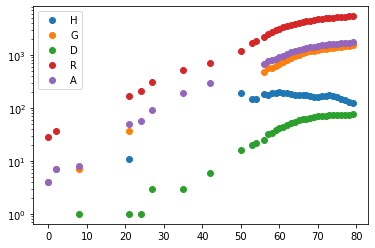

In [5]:
plt.semilogy(time, H, 'o', time, G, 'o', time, D, 'o', time, cE, 'o', time , cH, 'o')
plt.legend("HGDRA")

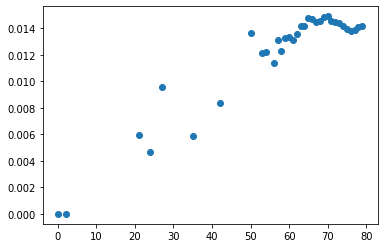

In [6]:
plt.plot(time,[d/ce if ce else None for d,ce in zip(D,cE)],'o')

In [7]:
data_pd = np.vstack([H, G, D, cE, cH]).astype(float).T
start = 0
data_time = time[start:]
data_pd = data_pd[start:,:]

p0 = [1.5, 1e-6, 0, 1e-6, 1e-6, 0.015]
config = {
    "grid_size": 77*2,
    "basis_number": 40,
    "model_form": {
        "state": 9,
        "parameters": 6
    },
    "time_span": [time[0], time[-1]*1.5],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(data_time)},
    "observation_vector": [3,4,6,7,8],
    "weightings":[
        [1]*9,
        np.sqrt((data_time+1)/np.mean(data_time+1))
    ],
    "regularisation_value": copy(p0),
}

In [8]:
model = modeller.Model(config)
config['regularisation_value'][0] = model.ps[0]
config['regularisation_value'][2] = model.ps[2]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 10,
        
    }
}
solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [9]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [10]:
c0 = [2500*np.ones(config['basis_number']) for _ in range(9)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*9) + [0]*len(config['regularisation_value'])
alpha = 1e2

In [11]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     5166
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

(0, 3000)

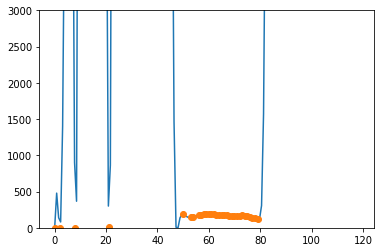

In [12]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[3])
plt.plot(time, H, 'o')
plt.ylim([0, 3000])

In [13]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     5166
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1386
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1386
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

 280  1.1218236e+02 0.00e+00 2.48e-02  -8.6 6.55e+01    -  1.00e+00 5.00e-01h  2
 290  1.1218236e+02 0.00e+00 3.40e-03  -8.6 2.50e+01    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.1218236e+02 0.00e+00 4.81e-02  -8.6 2.53e+02    -  1.00e+00 6.25e-02h  5
 310  1.1218236e+02 0.00e+00 1.94e-03  -8.6 1.28e+01    -  1.00e+00 1.00e+00h  1
 320  1.1218236e+02 0.00e+00 1.54e-04  -8.6 4.17e+00    -  1.00e+00 1.00e+00h  1
 330  1.1218236e+02 0.00e+00 1.02e-03  -8.6 1.12e+01    -  1.00e+00 1.00e+00h  1
 340  1.1218236e+02 0.00e+00 2.79e-04  -8.6 6.51e+00    -  1.00e+00 1.00e+00h  1
 350  1.1218236e+02 0.00e+00 5.12e-03  -8.6 5.05e+01    -  1.00e+00 5.00e-01h  2
 360  1.1218236e+02 0.00e+00 2.62e-03  -8.6 2.27e+01    -  1.00e+00 1.00e+00h  1
 370  1.1218236e+02 0.00e+00 3.15e-03  -8.6 3.02e+02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 371

                                   (scaled)                 (unscaled)
Object

 540  1.1262157e+02 0.00e+00 2.49e-04  -9.0 3.29e+01    -  1.00e+00 1.00e+00h  1
 550  1.1262157e+02 0.00e+00 6.16e-05  -9.0 1.73e+01    -  1.00e+00 1.00e+00h  1
 560  1.1262157e+02 0.00e+00 3.43e-04  -9.0 4.20e+01    -  1.00e+00 1.00e+00h  1
 570  1.1262157e+02 0.00e+00 1.70e-04  -9.0 3.09e+01    -  1.00e+00 1.00e+00h  1
 580  1.1262157e+02 0.00e+00 3.00e-07  -9.0 4.41e+00    -  1.00e+00 1.00e+00h  1
 590  1.1262157e+02 0.00e+00 7.27e-06  -9.0 7.68e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.1262157e+02 0.00e+00 7.14e-06  -9.0 7.89e+00    -  1.00e+00 1.00e+00h  1
 610  1.1262157e+02 0.00e+00 3.42e-05  -9.0 1.65e+01    -  1.00e+00 1.00e+00h  1
 620  1.1262157e+02 0.00e+00 3.21e-01  -9.0 1.28e+03    -  1.00e+00 6.25e-02h  5
 630  1.1262157e+02 0.00e+00 3.50e-02  -9.0 2.61e+02    -  1.00e+00 5.00e-01h  2
 640  1.1262157e+02 0.00e+00 1.83e-05  -9.0 1.38e+01    -  1.00e+00 1.00e+00h  1
 650  1.1262157e+02 0.00e+00

 370  1.1313858e+02 0.00e+00 3.28e-03  -9.0 3.82e+01    -  1.00e+00 1.00e+00h  1
 380  1.1313858e+02 0.00e+00 1.86e-03  -9.0 3.12e+01    -  1.00e+00 1.00e+00h  1
 390  1.1313858e+02 0.00e+00 1.12e-01  -9.0 4.40e+02    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.1313858e+02 0.00e+00 4.09e-03  -9.0 5.27e+01    -  1.00e+00 1.00e+00h  1
 410  1.1313858e+02 0.00e+00 5.16e-03  -9.0 6.29e+01    -  1.00e+00 1.00e+00h  1
 420  1.1313858e+02 0.00e+00 5.16e-01  -9.0 1.80e+03    -  1.00e+00 1.56e-02h  7
 430  1.1313858e+02 0.00e+00 2.23e-04  -9.0 1.52e+01    -  1.00e+00 1.00e+00h  1
 440  1.1313858e+02 0.00e+00 6.81e-05  -9.0 9.12e+00    -  1.00e+00 1.00e+00h  1
 450  1.1313858e+02 0.00e+00 1.04e-01  -9.0 4.09e+02    -  1.00e+00 1.25e-01h  4
 460  1.1313858e+02 0.00e+00 1.11e-02  -9.0 7.65e+01    -  1.00e+00 5.00e-01h  2
 470  1.1313858e+02 0.00e+00 4.53e-03  -9.0 8.27e+01    -  1.00e+00 1.00e+00H  1
 480  1.1313858e+02 0.00e+00

 490  1.1365543e+02 0.00e+00 4.90e-05  -9.0 7.26e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.1365543e+02 0.00e+00 3.52e-05  -9.0 6.75e+00    -  1.00e+00 1.00e+00h  1
 510  1.1365543e+02 0.00e+00 3.42e-04  -9.0 2.08e+01    -  1.00e+00 1.00e+00h  1
 520  1.1365543e+02 0.00e+00 1.51e-04  -9.0 1.46e+01    -  1.00e+00 1.00e+00h  1
 530  1.1365543e+02 0.00e+00 2.07e-04  -9.0 1.78e+01    -  1.00e+00 1.00e+00h  1
 540  1.1365543e+02 0.00e+00 8.32e-05  -9.0 1.20e+01    -  1.00e+00 1.00e+00h  1
 550  1.1365543e+02 0.00e+00 1.47e-03  -9.0 5.44e+01    -  1.00e+00 1.00e+00h  1
 560  1.1365543e+02 0.00e+00 2.84e-04  -9.0 2.51e+01    -  1.00e+00 1.00e+00h  1
 570  1.1365543e+02 0.00e+00 1.31e-04  -9.0 1.78e+01    -  1.00e+00 1.00e+00h  1
 580  1.1365543e+02 0.00e+00 5.12e-05  -9.0 1.17e+01    -  1.00e+00 1.00e+00h  1
 590  1.1365543e+02 0.00e+00 1.10e-04  -9.0 1.75e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 


Number of Iterations....: 1465

                                   (scaled)                 (unscaled)
Objective...............:   1.1344500258280758e+02    1.1344500258280758e+02
Dual infeasibility......:   4.5038177631795406e-09    4.5038177631795406e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909263046e-10    9.0909090909263046e-10
Overall NLP error.......:   4.5038177631795406e-09    4.5038177631795406e-09


Number of objective function evaluations             = 2882
Number of objective gradient evaluations             = 1466
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 2882
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 1466
Number of Lagrangian Hessian evaluations             = 1465
Total CPU secs in IPOPT (w/o function evaluations)   =      6.266
Total CPU secs in NLP functio

 190  1.1477284e+02 0.00e+00 2.01e-01  -8.6 8.78e+01    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.1477284e+02 0.00e+00 5.53e-03  -8.6 3.95e+01    -  1.00e+00 1.00e+00h  1
 210  1.1477283e+02 0.00e+00 4.02e-02  -8.6 2.49e+01    -  1.00e+00 2.50e-01h  3
 220  1.1477285e+02 0.00e+00 7.28e-01  -8.6 3.19e+01    -  1.00e+00 5.00e-01h  2
 230  1.1477283e+02 0.00e+00 1.46e-02  -8.6 2.55e+01    -  1.00e+00 1.00e+00h  1
 240  1.1477283e+02 0.00e+00 1.61e-02  -8.6 4.99e+00    -  1.00e+00 1.00e+00h  1
 250  1.1477283e+02 0.00e+00 8.30e-02  -8.6 6.59e+01    -  1.00e+00 5.00e-01h  2
 260  1.1477283e+02 0.00e+00 4.42e-03  -8.6 2.53e+00    -  1.00e+00 1.00e+00h  1
 270  1.1477283e+02 0.00e+00 1.38e-03  -8.6 1.75e+00    -  1.00e+00 1.00e+00h  1
 280  1.1477283e+02 0.00e+00 1.39e-03  -8.6 2.02e+00    -  1.00e+00 1.00e+00h  1
 290  1.1477283e+02 0.00e+00 4.34e-03  -8.6 3.93e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

  30  1.1584201e+02 0.00e+00 2.40e+00  -3.8 2.35e+03 -11.6 1.00e+00 1.00e+00f  1
  40  1.1584415e+02 0.00e+00 4.90e+00  -3.8 1.31e+04    -  7.31e-01 2.50e-01f  3
  50  1.1585094e+02 0.00e+00 1.06e+01  -3.8 1.31e+04    -  1.00e+00 5.00e-01f  2
  60  1.1585352e+02 0.00e+00 4.05e+00  -3.8 7.33e+03    -  1.00e+00 5.00e-01f  2
  70  1.1585853e+02 0.00e+00 2.17e+00  -3.8 1.31e+03 -12.8 1.00e+00 1.00e+00f  1
  80  1.1586151e+02 0.00e+00 1.25e+00  -3.8 1.22e+03 -12.1 1.00e+00 1.00e+00f  1
  90  1.1586319e+02 0.00e+00 2.16e+00  -3.8 8.42e+03    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1585341e+02 0.00e+00 2.57e+00  -5.7 1.92e+04    -  5.94e-01 5.98e-01f  1
 110  1.1584325e+02 0.00e+00 1.44e-02  -5.7 3.51e+02 -12.9 1.00e+00 1.00e+00f  1
 120  1.1584311e+02 0.00e+00 7.96e-01  -5.7 1.75e+03 -15.0 1.00e+00 1.00e+00h  1
 130  1.1584279e+02 0.00e+00 1.10e+00  -5.7 4.82e+03 -13.4 1.00e+00 2.50e-01f  3
 140  1.1584195e+02 0.00e+00

 260  1.1619544e+02 0.00e+00 1.29e+00  -5.7 8.83e+02 -13.3 1.00e+00 7.58e-01f  1
 270  1.1619426e+02 0.00e+00 5.62e-01  -5.7 2.58e+03 -13.6 1.00e+00 2.37e-01f  3
 280  1.1619339e+02 0.00e+00 5.42e-01  -5.7 1.73e+03 -11.1 5.33e-01 2.60e-01f  2
 290  1.1619273e+02 0.00e+00 2.69e-01  -5.7 1.34e+03 -13.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.1619221e+02 0.00e+00 1.12e-01  -5.7 2.37e+02 -12.5 1.00e+00 1.00e+00f  1
 310  1.1619187e+02 0.00e+00 1.05e-01  -5.7 9.16e+02 -12.8 2.23e-01 1.00e+00f  1
 320  1.1619163e+02 0.00e+00 1.78e-01  -5.7 1.15e+04    -  1.00e+00 1.25e-01f  4
 330  1.1619143e+02 0.00e+00 9.76e-02  -5.7 3.21e+03 -10.5 6.69e-01 1.04e-02f  5
 340  1.1619135e+02 0.00e+00 2.03e-01  -5.7 1.01e+04    -  1.00e+00 1.25e-01h  4
 350  1.1619127e+02 0.00e+00 7.30e-02  -5.7 3.17e+03    -  1.00e+00 2.50e-01h  3
 360  1.1619110e+02 0.00e+00 2.19e-01  -8.6 4.89e+02 -11.4 3.07e-01 2.47e-01f  3
 370  1.1619105e+02 0.00e+00

  60  1.1692634e+02 0.00e+00 2.14e-01  -5.7 8.90e+02 -12.4 1.00e+00 2.50e-01f  3
  70  1.1692563e+02 0.00e+00 2.82e-01  -5.7 2.67e+03 -12.7 1.00e+00 5.00e-01f  2
  80  1.1692517e+02 0.00e+00 2.05e-01  -5.7 2.32e+02 -12.0 1.00e+00 1.00e+00h  1
  90  1.1692491e+02 0.00e+00 9.82e-02  -5.7 1.92e+04    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1692483e+02 0.00e+00 1.76e-02  -8.6 4.30e+03    -  8.77e-01 1.90e-01f  3
 110  1.1692467e+02 0.00e+00 7.01e-04  -8.6 1.23e+01  -9.8 1.00e+00 1.00e+00f  1
 120  1.1692465e+02 0.00e+00 1.31e-03  -8.6 1.47e+01 -12.1 1.00e+00 1.00e+00h  1

Number of Iterations....: 126

                                   (scaled)                 (unscaled)
Objective...............:   1.1692464973586890e+02    1.1692464973586890e+02
Dual infeasibility......:   5.7275675738881691e-09    5.7275675738881691e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

  40  1.1772233e+02 0.00e+00 2.19e-01  -3.8 1.91e+02 -10.4 1.00e+00 1.00e+00f  1
  50  1.1772330e+02 0.00e+00 2.22e+00  -3.8 9.67e+02 -12.7 1.00e+00 1.00e+00f  1
  60  1.1772475e+02 0.00e+00 7.60e+00  -3.8 2.29e+03    -  1.00e+00 5.00e-01f  2
  70  1.1772473e+02 0.00e+00 3.71e+00  -3.8 4.58e+03    -  1.00e+00 2.50e-01f  3
  80  1.1772507e+02 0.00e+00 2.09e-01  -3.8 1.16e+03 -12.2 1.00e+00 1.00e+00f  1
  90  1.1771698e+02 0.00e+00 4.54e-01  -5.7 4.52e+03    -  7.88e-01 4.59e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1770851e+02 0.00e+00 7.88e-02  -5.7 7.13e+02 -13.3 1.00e+00 1.00e+00h  1
 110  1.1770847e+02 0.00e+00 4.60e-02  -5.7 2.01e+02 -13.9 1.00e+00 1.00e+00h  1
 120  1.1770845e+02 0.00e+00 1.00e+00  -5.7 4.16e+03 -13.6 1.00e+00 2.10e-01H  1
 130  1.1770839e+02 0.00e+00 3.78e-01  -5.7 2.10e+03    -  1.00e+00 5.00e-01h  2
 140  1.1770833e+02 0.00e+00 7.96e-01  -5.7 2.34e+03    -  1.00e+00 2.50e-01h  3
 150  1.1770826e+02 0.00e+00

 120  1.1809308e+02 0.00e+00 3.84e-01  -5.7 4.95e+02 -13.6 1.00e+00 5.00e-01h  2
 130  1.1809298e+02 0.00e+00 4.51e-01  -5.7 2.73e+02 -13.8 1.00e+00 1.00e+00h  1
 140  1.1809287e+02 0.00e+00 6.89e-01  -5.7 5.10e+02 -13.6 1.00e+00 5.00e-01h  2
 150  1.1809273e+02 0.00e+00 1.99e+00  -5.7 8.16e+02 -13.4 1.00e+00 5.00e-01h  2
 160  1.1809248e+02 0.00e+00 2.62e-01  -5.7 1.36e+02 -13.2 1.00e+00 1.00e+00h  1
 170  1.1809205e+02 0.00e+00 7.35e-01  -5.7 1.88e+02 -12.9 1.00e+00 1.00e+00h  1
 180  1.1809154e+02 0.00e+00 2.11e+00  -5.7 7.93e+02 -13.2 1.00e+00 5.00e-01f  2
 190  1.1809073e+02 0.00e+00 5.14e-01  -5.7 2.27e+02 -12.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.1808948e+02 0.00e+00 2.73e+00  -5.7 9.20e+02 -12.8 1.00e+00 1.00e+00f  1
 210  1.1808736e+02 0.00e+00 1.77e+00  -5.7 5.90e+02 -11.2 9.76e-01 2.50e-01f  3
 220  1.1808341e+02 0.00e+00 4.37e+00  -5.7 1.04e+04 -10.6 5.81e-02 2.89e-02f  5
 230  1.1807724e+02 0.00e+00

 390  1.1844252e+02 0.00e+00 2.45e-02  -8.6 3.54e+01  -9.8 7.24e-01 7.94e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.1844226e+02 0.00e+00 7.74e-04  -8.6 2.46e+04    -  7.79e-02 4.55e-02f  1
 410  1.1844225e+02 0.00e+00 5.36e-09  -8.6 3.05e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 410

                                   (scaled)                 (unscaled)
Objective...............:   1.1844224644486751e+02    1.1844224644486751e+02
Dual infeasibility......:   5.3566447102240687e-09    5.3566447102240687e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    2.5059035596800626e-09
Overall NLP error.......:   5.3566447102240687e-09    5.3566447102240687e-09


Number of objective function evaluations             = 723
Number of objective gradient evaluations             = 411
Number of equality constraint evaluations            = 0
Number of i

  20  1.5702121e+02 0.00e+00 2.48e+03  -1.0 1.24e+04    -  6.72e-01 1.00e+00f  1
  30  1.2876595e+02 0.00e+00 6.20e+01  -1.7 4.35e+03    -  1.00e+00 7.15e-01f  1
  40  1.1943929e+02 0.00e+00 6.37e-02  -3.8 2.58e+02  -9.2 1.00e+00 1.00e+00f  1
  50  1.1936991e+02 0.00e+00 2.96e+00  -3.8 1.38e+03 -11.7 1.00e+00 2.79e-01f  2
  60  1.1935724e+02 0.00e+00 1.18e-01  -5.7 5.41e+02 -12.7 1.00e+00 1.00e+00f  1
  70  1.1935704e+02 0.00e+00 4.64e-01  -5.7 3.11e+04    -  1.00e+00 1.56e-02h  7
  80  1.1935697e+02 0.00e+00 1.93e-02  -5.7 7.13e+01 -13.0 1.00e+00 1.00e+00h  1
  90  1.1935690e+02 0.00e+00 8.99e-01  -5.7 6.04e+03    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1935686e+02 0.00e+00 4.98e-01  -5.7 2.66e+04    -  1.00e+00 1.25e-01h  4
 110  1.1935677e+02 0.00e+00 8.01e-01  -5.7 3.20e+02 -12.7 1.00e+00 1.00e+00h  1
 120  1.1935666e+02 0.00e+00 2.13e+00  -5.7 8.97e+02 -13.3 1.00e+00 5.00e-01h  2
 130  1.1935651e+02 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     5166
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1386
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1386
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2056292e+02 0.00e+00 6.99e+01  -1.0 0.00e+00    -  0.00e+00 0.

 230  1.2072883e+02 0.00e+00 8.40e+00  -5.7 5.03e+03 -11.7 1.00e+00 1.48e-01f  3
 240  1.2069056e+02 0.00e+00 2.49e+01  -5.7 6.41e+02 -10.2 1.00e+00 1.00e+00f  1
 250  1.2060241e+02 0.00e+00 2.46e+01  -5.7 2.44e+03    -  7.99e-02 1.89e-01f  1
 260  1.2047814e+02 0.00e+00 1.19e+01  -5.7 2.33e+03    -  5.25e-02 4.06e-01f  1
 270  1.2041617e+02 0.00e+00 2.65e-01  -5.7 1.27e+02    -  2.78e-01 6.54e-01f  1
 280  1.2039785e+02 0.00e+00 1.78e-01  -5.7 1.20e+02    -  1.00e+00 1.00e+00f  1
 290  1.2039288e+02 0.00e+00 3.90e-01  -5.7 1.20e+02 -11.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.2038977e+02 0.00e+00 7.75e-02  -5.7 3.48e+02    -  1.00e+00 1.93e-01f  2
 310  1.2038902e+02 0.00e+00 2.91e-02  -5.7 3.24e+01    -  1.00e+00 1.00e+00f  1
 320  1.2038885e+02 0.00e+00 2.79e-04  -5.7 7.21e+00    -  1.00e+00 1.00e+00h  1
 330  1.2038848e+02 0.00e+00 2.31e-04  -8.6 2.94e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 3

 250  1.2149722e+02 0.00e+00 1.50e+01  -5.7 1.91e+03 -11.0 1.38e-01 6.08e-01f  1
 260  1.2142051e+02 0.00e+00 8.51e-01  -5.7 6.21e+01  -7.1 5.71e-01 1.00e+00f  1
 270  1.2138160e+02 0.00e+00 1.77e-01  -5.7 2.09e+03    -  4.55e-01 2.12e-01f  1
 280  1.2137472e+02 0.00e+00 1.14e-02  -5.7 2.10e+01  -8.9 1.00e+00 1.00e+00f  1
 290  1.2137364e+02 0.00e+00 8.45e-06  -5.7 1.70e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.2137339e+02 0.00e+00 7.25e-09  -8.6 7.09e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:   1.2137339322769026e+02    1.2137339322769026e+02
Dual infeasibility......:   7.2470715783102275e-09    7.2470715783102275e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.5118800994486204e-09    4.5118800994486204e-09
Overall NLP error.....

  60  1.2271967e+02 0.00e+00 3.59e-02  -3.8 1.21e+01  -6.8 1.00e+00 1.00e+00f  1
  70  1.2269801e+02 0.00e+00 4.59e-01  -5.7 1.49e+04    -  1.00e+00 1.00e+00f  1
  80  1.2269754e+02 0.00e+00 8.37e-02  -8.6 1.62e+01  -8.7 7.03e-01 5.82e-01f  1

Number of Iterations....: 86

                                   (scaled)                 (unscaled)
Objective...............:   1.2269751225156351e+02    1.2269751225156351e+02
Dual infeasibility......:   9.5503688739092640e-11    9.5503688739092640e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5718012185206584e-09    2.5718012185206584e-09
Overall NLP error.......:   2.5718012185206584e-09    2.5718012185206584e-09


Number of objective function evaluations             = 114
Number of objective gradient evaluations             = 87
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 114
Number of equality constraint Jacob

  40  1.4590441e+02 0.00e+00 1.99e+03  -1.0 1.26e+04    -  1.00e+00 5.00e-01f  2
  50  1.2943939e+02 0.00e+00 5.00e+02  -2.5 1.21e+04    -  7.70e-01 1.00e+00f  1
  60  1.2742949e+02 0.00e+00 5.46e+01  -2.5 2.87e+03    -  1.00e+00 5.00e-01f  2
  70  1.2715551e+02 0.00e+00 3.54e+00  -3.8 4.06e+02 -11.4 1.00e+00 1.00e+00f  1
  80  1.2715299e+02 0.00e+00 8.76e-02  -3.8 1.16e+02    -  1.00e+00 1.00e+00h  1
  90  1.2714536e+02 0.00e+00 3.40e+01  -5.7 2.95e+03 -12.5 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2714364e+02 0.00e+00 1.75e-01  -5.7 9.86e+01 -10.9 1.00e+00 1.00e+00f  1
 110  1.2714218e+02 0.00e+00 7.54e+00  -5.7 2.08e+03 -12.1 1.00e+00 2.50e-01f  3
 120  1.2714023e+02 0.00e+00 4.23e+00  -5.7 3.53e+02 -11.4 1.00e+00 1.00e+00f  1
 130  1.2713796e+02 0.00e+00 6.04e+00  -5.7 7.63e+02 -11.7 1.00e+00 5.00e-01f  2
 140  1.2713433e+02 0.00e+00 1.40e+01  -5.7 2.20e+03 -11.9 1.00e+00 1.00e+00f  1
 150  1.2712877e+02 0.00e+00

  10  1.4253681e+02 0.00e+00 1.72e+02  -1.0 8.72e+03    -  5.91e-02 5.94e-02f  2
  20  1.4804056e+02 0.00e+00 8.45e+00  -1.0 1.38e+02  -5.9 1.00e+00 1.00e+00f  1
  30  1.4867130e+02 0.00e+00 6.57e+02  -1.0 2.76e+03  -8.3 1.00e+00 1.00e+00f  1
  40  1.4895046e+02 0.00e+00 4.31e+02  -1.0 4.49e+03  -8.9 1.00e+00 1.00e+00f  1
  50  1.4952904e+02 0.00e+00 7.75e+01  -1.0 7.44e+02  -9.1 1.00e+00 1.00e+00f  1
  60  1.3479841e+02 0.00e+00 3.48e+01  -1.7 1.11e+03    -  1.00e+00 1.00e+00f  1
  70  1.3198718e+02 0.00e+00 5.18e+01  -3.8 2.23e+03    -  9.75e-01 6.51e-01f  1
  80  1.3189343e+02 0.00e+00 3.02e+01  -3.8 9.60e+03    -  1.00e+00 1.25e-01f  4
  90  1.3188914e+02 0.00e+00 5.02e+00  -3.8 4.87e+02 -11.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.3188712e+02 0.00e+00 7.21e-01  -3.8 2.01e+02 -12.0 1.00e+00 1.00e+00f  1
 110  1.3188578e+02 0.00e+00 3.49e-01  -3.8 6.65e+01 -11.3 1.00e+00 1.00e+00f  1
 120  1.3188399e+02 0.00e+00

Number of inequality constraint Jacobian evaluations = 293
Number of Lagrangian Hessian evaluations             = 292
Total CPU secs in IPOPT (w/o function evaluations)   =      1.958
Total CPU secs in NLP function evaluations           =      0.409

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  32.79ms ( 65.98us)  32.92ms ( 66.23us)       497
       nlp_g  |  16.72ms ( 33.63us)  16.66ms ( 33.53us)       497
    nlp_grad  | 166.00us (166.00us) 165.05us (165.05us)         1
  nlp_grad_f  |  41.14ms (139.94us)  41.12ms (139.85us)       294
  nlp_hess_l  | 302.56ms (  1.04ms) 302.41ms (  1.04ms)       292
   nlp_jac_g  |  13.23ms ( 45.01us)  13.27ms ( 45.14us)       294
       total  |   2.39 s (  2.39 s)   2.39 s (  2.39 s)         1
Solving for p=0.004328761281083062
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of non

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     5166
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1386
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1386
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.3758971e+02 0.00e+00 1.71e+02  -1.0 0.00e+00    -  0.00e+00 0.

  40  1.4279506e+02 0.00e+00 1.08e-02  -5.7 3.37e+00  -8.3 1.00e+00 1.00e+00f  1
  50  1.4279492e+02 0.00e+00 2.74e-09  -8.6 4.59e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 50

                                   (scaled)                 (unscaled)
Objective...............:   1.4279491802629008e+02    1.4279491802629008e+02
Dual infeasibility......:   2.7427495183686950e-09    2.7427495183686950e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8235806158911037e-09    2.8235806158911037e-09
Overall NLP error.......:   2.8235806158911037e-09    2.8235806158911037e-09


Number of objective function evaluations             = 70
Number of objective gradient evaluations             = 51
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 70
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 51
Num


Number of Iterations....: 49

                                   (scaled)                 (unscaled)
Objective...............:   1.5115616920622770e+02    1.5115616920622770e+02
Dual infeasibility......:   5.9902256990710697e-09    5.9902256990710697e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.3190225728681570e-09    3.3190225728681570e-09
Overall NLP error.......:   5.9902256990710697e-09    5.9902256990710697e-09


Number of objective function evaluations             = 67
Number of objective gradient evaluations             = 50
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 67
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 50
Number of Lagrangian Hessian evaluations             = 49
Total CPU secs in IPOPT (w/o function evaluations)   =      0.220
Total CPU secs in NLP function evaluation

  30  2.1409383e+02 0.00e+00 7.23e+00  -1.0 3.93e+01  -5.6 1.00e+00 1.00e+00f  1
  40  1.8778239e+02 0.00e+00 5.80e+00  -2.5 6.98e+01  -6.2 2.93e-01 1.00e+00f  1
  50  1.7978724e+02 0.00e+00 6.57e+02  -2.5 4.23e+02  -7.7 1.00e+00 1.00e+00f  1
  60  1.7207262e+02 0.00e+00 4.45e+00  -2.5 1.59e+01  -5.2 1.00e+00 1.00e+00f  1
  70  1.7103572e+02 0.00e+00 4.18e-01  -3.8 9.65e+00  -7.2 1.00e+00 9.53e-01f  1
  80  1.7101888e+02 0.00e+00 5.14e-01  -5.7 7.42e+03    -  1.00e+00 3.71e-01f  2

Number of Iterations....: 88

                                   (scaled)                 (unscaled)
Objective...............:   1.7101862243184939e+02    1.7101862243184939e+02
Dual infeasibility......:   1.1355969776196077e-10    1.1355969776196077e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8073491106712742e-09    2.8073491106712742e-09
Overall NLP error.......:   2.8073491106712742e-09    2.8073491106712742e-09


Number of objective funct

  60  2.0548546e+02 0.00e+00 1.92e-02  -3.8 1.79e+03    -  1.00e+00 1.00e+00f  1
  70  2.0547519e+02 0.00e+00 6.93e-09  -5.7 4.43e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 75

                                   (scaled)                 (unscaled)
Objective...............:   2.0547506470129582e+02    2.0547506470129582e+02
Dual infeasibility......:   1.4181418301440848e-09    1.4181418301440848e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.9887396399729229e-09    2.9887396399729229e-09
Overall NLP error.......:   2.9887396399729229e-09    2.9887396399729229e-09


Number of objective function evaluations             = 109
Number of objective gradient evaluations             = 76
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 109
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 76
N

  40  2.6741742e+02 0.00e+00 6.26e+02  -3.8 6.61e+02    -  8.20e-01 5.00e-01f  2
  50  2.6546895e+02 0.00e+00 1.49e+01  -3.8 1.66e+04    -  1.00e+00 1.00e+00f  1
  60  2.6544987e+02 0.00e+00 2.54e-01  -5.7 1.36e+03    -  1.00e+00 8.49e-01f  1

Number of Iterations....: 67

                                   (scaled)                 (unscaled)
Objective...............:   2.6544985744215052e+02    2.6544985744215052e+02
Dual infeasibility......:   9.4173770496939360e-10    9.4173770496939360e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.4992295612081336e-09    2.4992295612081336e-09
Overall NLP error.......:   2.4992295612081336e-09    2.4992295612081336e-09


Number of objective function evaluations             = 103
Number of objective gradient evaluations             = 68
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 103
Number of equality constraint Jacob

  30  3.6824493e+02 0.00e+00 4.67e+00  -3.8 2.35e+04    -  1.00e+00 1.00e+00f  1
  40  3.6822947e+02 0.00e+00 5.15e-05  -8.6 7.70e+01    -  1.00e+00 7.62e-01f  1

Number of Iterations....: 42

                                   (scaled)                 (unscaled)
Objective...............:   3.6822946775082210e+02    3.6822946775082210e+02
Dual infeasibility......:   4.0516532225717447e-11    4.0516532225717447e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8145228313749511e-09    2.8145228313749511e-09
Overall NLP error.......:   2.8145228313749511e-09    2.8145228313749511e-09


Number of objective function evaluations             = 56
Number of objective gradient evaluations             = 43
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 56
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 43
Num

  10  6.2349520e+02 0.00e+00 3.70e+02  -1.7 1.04e+04    -  7.83e-01 1.00e+00f  1
  20  6.2154888e+02 0.00e+00 1.11e-01  -3.8 9.35e+02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 27

                                   (scaled)                 (unscaled)
Objective...............:   6.2153150074236669e+02    6.2153150074236669e+02
Dual infeasibility......:   9.0444731381642391e-11    9.0444731381642391e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.1217417281382440e-09    3.1217417281382440e-09
Overall NLP error.......:   3.1217417281382440e-09    3.1217417281382440e-09


Number of objective function evaluations             = 30
Number of objective gradient evaluations             = 28
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 30
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 28
Num

  10  1.0772049e+03 0.00e+00 1.21e+02  -1.7 2.58e+03    -  1.00e+00 1.00e+00f  1
  20  1.0751316e+03 0.00e+00 6.36e-02  -3.8 4.17e+00  -4.4 9.63e-01 1.00e+00f  1
  30  1.0747794e+03 0.00e+00 3.67e-05  -8.6 1.48e+01    -  1.00e+00 7.56e-01f  1

Number of Iterations....: 32

                                   (scaled)                 (unscaled)
Objective...............:   1.0747794010470941e+03    1.0747794010470941e+03
Dual infeasibility......:   4.1051867628590307e-10    4.1051867628590307e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5264518822778029e-09    2.5264518822778029e-09
Overall NLP error.......:   2.5264518822778029e-09    2.5264518822778029e-09


Number of objective function evaluations             = 41
Number of objective gradient evaluations             = 33
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 41
Number of equality constraint Jacobia

  30  1.5517011e+03 0.00e+00 1.84e-04  -8.6 1.33e+01    -  1.00e+00 7.86e-01f  1

Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:   1.5517010715681324e+03    1.5517010715681324e+03
Dual infeasibility......:   1.7568630179703737e-10    1.7568630179703737e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0719921947009207e-09    3.0719921947009207e-09
Overall NLP error.......:   3.0719921947009207e-09    3.0719921947009207e-09


Number of objective function evaluations             = 37
Number of objective gradient evaluations             = 34
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 37
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 34
Number of Lagrangian Hessian evaluations             = 33
Total CPU secs in IPOPT (w

  20  2.1067846e+03 0.00e+00 5.07e-04  -3.8 5.89e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 29

                                   (scaled)                 (unscaled)
Objective...............:   2.1067666973358400e+03    2.1067666973358400e+03
Dual infeasibility......:   2.5321350181422430e-10    2.5321350181422430e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   7.8641296363879399e-09    7.8641296363879399e-09
Overall NLP error.......:   7.8641296363879399e-09    7.8641296363879399e-09


Number of objective function evaluations             = 30
Number of objective gradient evaluations             = 30
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 30
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 30
Number of Lagrangian Hessian evaluations             = 29
Total CPU secs in IPOPT (w

  20  2.9264186e+03 0.00e+00 4.98e+01  -1.7 1.20e+03    -  1.00e+00 1.00e+00f  1
  30  2.9252868e+03 0.00e+00 4.82e+00  -3.8 3.92e+03    -  1.00e+00 1.00e+00f  1
  40  2.9252698e+03 0.00e+00 1.31e-03  -8.6 5.59e+01    -  1.00e+00 7.87e-01f  1

Number of Iterations....: 42

                                   (scaled)                 (unscaled)
Objective...............:   2.9252698382322187e+03    2.9252698382322187e+03
Dual infeasibility......:   3.3768953355077807e-09    3.3768953355077807e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.8432135379810164e-09    3.8432135379810164e-09
Overall NLP error.......:   3.8432135379810164e-09    3.8432135379810164e-09


Number of objective function evaluations             = 55
Number of objective gradient evaluations             = 43
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 55
Number of equality constraint Jacobia

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     5166
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1386
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1386
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.8834780e+03 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.

  30  4.5754684e+03 0.00e+00 4.80e+02  -1.7 1.27e+04    -  1.00e+00 5.00e-01f  2
  40  4.5743631e+03 0.00e+00 3.45e-04  -3.8 9.68e-02  -5.6 1.00e+00 1.00e+00h  1
  50  4.5743520e+03 0.00e+00 6.02e+00  -5.7 8.55e+02 -10.4 1.00e+00 1.00e+00f  1
  60  4.5742836e+03 0.00e+00 1.06e+02  -5.7 1.61e+02  -8.8 1.00e+00 5.00e-01f  2
  70  4.5742184e+03 0.00e+00 5.85e+01  -5.7 3.76e+01  -8.2 1.00e+00 5.00e-01f  2
  80  4.5741345e+03 0.00e+00 2.34e+02  -5.7 1.86e+03 -10.2 1.00e+00 1.00e+00f  1
  90  4.5739426e+03 0.00e+00 1.31e+01  -5.7 1.71e+01  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.5737503e+03 0.00e+00 1.08e+02  -5.7 2.43e+03  -9.8 1.00e+00 2.50e-01f  3
 110  4.5735927e+03 0.00e+00 8.20e+01  -5.7 1.04e+02  -8.3 1.00e+00 1.00e+00f  1
 120  4.5734406e+03 0.00e+00 2.24e+00  -5.7 1.91e+01  -7.6 1.00e+00 1.00e+00f  1
 130  4.5731307e+03 0.00e+00 1.38e+02  -5.7 7.42e+01    -  1.00e+00 3.91e-03f  9

Number of Iterations....: 1

  20  5.1541356e+03 0.00e+00 9.68e+03  -1.0 3.69e+03    -  7.72e-01 5.00e-01f  2
  30  5.1472414e+03 0.00e+00 3.72e+02  -1.0 3.82e-01  -0.8 1.00e+00 1.00e+00f  1
  40  5.1441548e+03 0.00e+00 1.72e+03  -1.0 1.43e+04    -  1.00e+00 6.25e-02f  5
  50  5.1424186e+03 0.00e+00 1.37e+03  -1.0 2.06e+01  -5.7 1.00e+00 1.00e+00f  1
  60  5.1375618e+03 0.00e+00 7.09e+01  -1.7 5.27e+00  -5.0 1.00e+00 1.00e+00f  1
  70  5.1366367e+03 0.00e+00 4.41e+02  -1.7 2.03e+01  -6.1 1.00e+00 1.00e+00f  1
  80  5.1358443e+03 0.00e+00 1.23e+03  -1.7 8.06e+00  -5.4 1.00e+00 1.00e+00f  1
  90  5.1354121e+03 0.00e+00 5.44e+00  -1.7 3.57e+00  -5.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.1351686e+03 0.00e+00 5.21e+02  -1.7 1.99e+01  -6.7 1.00e+00 1.00e+00f  1
 110  5.1350726e+03 0.00e+00 2.73e+02  -1.7 1.31e+01  -6.9 1.00e+00 1.00e+00f  1
 120  5.1350594e+03 0.00e+00 4.36e+02  -1.7 1.00e+01  -6.6 1.00e+00 1.00e+00f  1
 130r 1.6800788e+06 0.00e+00

 580  5.0304262e+03 0.00e+00 1.12e-01  -5.7 1.41e+00  -7.0 1.00e+00 1.00e+00f  1
 590  5.0300149e+03 0.00e+00 1.88e+00  -5.7 2.24e+03    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  5.0300064e+03 0.00e+00 3.41e+00  -8.6 1.99e+04    -  7.69e-01 1.25e-01h  4
 610  5.0299874e+03 0.00e+00 1.14e-05  -8.6 2.12e-01  -9.9 1.00e+00 1.00e+00h  1
 620  5.0299778e+03 0.00e+00 4.49e-01  -8.6 4.54e+01 -10.6 1.00e+00 2.50e-01h  3
 630  5.0299511e+03 0.00e+00 1.33e+00  -8.6 9.56e+09    -  8.15e-06 1.20e-07f  5
 640  5.0299433e+03 0.00e+00 5.53e-01  -8.6 1.40e+02 -11.9 1.00e+00 5.00e-01h  2
 650  5.0299377e+03 0.00e+00 2.95e-01  -8.6 1.46e+02 -12.2 1.00e+00 5.00e-01h  2
 660  5.0299316e+03 0.00e+00 1.53e-01  -8.6 6.48e+02 -12.4 1.00e+00 1.25e-01h  4
 670  5.0299235e+03 0.00e+00 7.27e-02  -8.6 3.44e+02 -12.7 1.00e+00 1.00e+00h  1
 680  5.0299138e+03 0.00e+00 1.70e-02  -8.6 8.64e+01 -12.0 1.00e+00 1.00e+00h  1
 690  5.0299057e+03 0.00e+00

 250  5.0677967e+03 0.00e+00 3.26e+02  -5.7 9.95e+01  -8.8 1.00e+00 5.00e-01f  2
 260  5.0677873e+03 0.00e+00 6.23e+01  -5.7 1.66e+01  -8.2 1.00e+00 1.00e+00f  1
 270  5.0677745e+03 0.00e+00 3.47e+02  -5.7 4.26e+01  -7.5 1.00e+00 2.50e-01f  3
 280  5.0677611e+03 0.00e+00 1.39e+02  -5.7 1.65e+02  -8.7 1.00e+00 2.50e-01f  3
 290  5.0677504e+03 0.00e+00 2.83e+00  -5.7 1.36e+01  -8.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  5.0677288e+03 0.00e+00 1.10e+02  -5.7 6.42e+00  -7.4 1.00e+00 1.00e+00f  1
 310  5.0677148e+03 0.00e+00 8.22e+02  -5.7 3.83e+02  -8.5 1.00e+00 1.25e-01f  4
 320  5.0676999e+03 0.00e+00 1.88e+02  -5.7 1.07e+02  -8.8 1.00e+00 1.00e+00f  1
 330  5.0676950e+03 0.00e+00 7.08e+00  -5.7 2.47e+01  -8.1 1.00e+00 1.00e+00f  1
 340  5.0676714e+03 0.00e+00 4.98e+02  -5.7 3.35e+02  -8.4 1.00e+00 1.25e-01f  4
 350  5.0676571e+03 0.00e+00 1.96e+02  -5.7 1.32e-01  -4.1 1.00e+00 1.00e+00f  1
 360  5.0676455e+03 0.00e+00

  50  5.1313199e+03 0.00e+00 5.31e+03  -1.7 1.20e+04    -  8.83e-01 3.12e-02f  6
  60  5.1310930e+03 0.00e+00 2.31e+02  -3.8 2.40e-01  -3.5 1.00e+00 1.00e+00f  1
  70  5.1310923e+03 0.00e+00 8.93e-01  -3.8 1.20e+01  -8.3 1.00e+00 1.00e+00f  1
  80  5.1310818e+03 0.00e+00 3.57e+02  -3.8 1.59e+00  -7.6 1.00e+00 1.00e+00f  1
  90  5.1310741e+03 0.00e+00 2.04e+02  -3.8 4.05e+01  -7.9 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.1310665e+03 0.00e+00 5.50e+02  -3.8 2.18e+01  -8.1 1.00e+00 1.00e+00f  1
 110  5.1310579e+03 0.00e+00 5.55e+02  -3.8 6.08e+01  -8.4 1.00e+00 5.00e-01f  2
 120  5.1310464e+03 0.00e+00 3.34e+02  -3.8 3.27e+01  -7.7 1.00e+00 2.50e-01f  3
 130  5.1310375e+03 0.00e+00 4.51e+02  -3.8 1.80e+01  -8.0 1.00e+00 1.00e+00f  1
 140  5.1310337e+03 0.00e+00 4.44e-02  -3.8 2.25e+00  -7.3 1.00e+00 1.00e+00f  1
 150  5.1310247e+03 0.00e+00 1.96e+01  -3.8 3.44e+01  -8.5 1.00e+00 1.00e+00f  1
 160  5.1310192e+03 0.00e+00

 240  5.1598092e+03 0.00e+00 9.51e+01  -3.8 4.05e+01  -8.2 1.00e+00 1.00e+00f  1
 250  5.1598048e+03 0.00e+00 5.10e+00  -3.8 9.29e+00  -7.6 1.00e+00 1.00e+00f  1
 260  5.1597965e+03 0.00e+00 1.16e+01  -3.8 3.00e-01  -6.0 1.00e+00 1.00e+00f  1
 270  5.1597837e+03 0.00e+00 1.13e+03  -3.8 3.42e+01  -8.1 1.00e+00 1.00e+00f  1
 280  5.1597738e+03 0.00e+00 3.21e+01  -3.8 7.74e+00  -7.5 1.00e+00 1.00e+00f  1
 290  5.1597624e+03 0.00e+00 3.48e+03  -3.8 1.22e+02  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  5.1597473e+03 0.00e+00 9.94e-01  -3.8 7.37e-02  -5.3 1.00e+00 1.00e+00h  1
 310  5.1597295e+03 0.00e+00 9.26e+02  -3.8 5.30e+01  -8.2 1.00e+00 1.00e+00f  1
 320  5.1597257e+03 0.00e+00 1.35e+01  -3.8 1.21e+01  -7.6 1.00e+00 1.00e+00f  1
 330  5.1597055e+03 0.00e+00 2.48e+02  -3.8 9.94e-02  -3.3 1.00e+00 1.00e+00f  1
 340  5.1597004e+03 0.00e+00 5.17e+01  -3.8 4.23e+01  -8.1 1.00e+00 1.00e+00f  1
 350  5.1596763e+03 0.00e+00

 480  5.1890395e+03 0.00e+00 1.37e-07  -9.0 2.17e-11    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 486

                                   (scaled)                 (unscaled)
Objective...............:   5.1890394827329073e+03    5.1890394827329073e+03
Dual infeasibility......:   2.0982354391053890e-07    2.0982354391053890e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    9.0909090909090931e-10
Overall NLP error.......:   2.0982354391053890e-07    2.0982354391053890e-07


Number of objective function evaluations             = 814
Number of objective gradient evaluations             = 487
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 814
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 487
Number of Lagrangian Hessian evaluations             = 486
Total CPU secs in IP

  30  5.2562479e+03 0.00e+00 3.68e+04  -1.7 3.78e+03    -  8.12e-01 1.25e-01f  4
  40  5.2557355e+03 0.00e+00 1.23e-02  -1.7 2.66e-02  -1.6 1.00e+00 1.00e+00f  1
  50  5.2554630e+03 0.00e+00 1.19e+00  -3.8 6.74e-02  -5.9 1.00e+00 1.00e+00h  1
  60  5.2554624e+03 0.00e+00 2.99e+02  -3.8 1.34e+01  -8.8 1.00e+00 1.00e+00f  1
  70  5.2554616e+03 0.00e+00 4.36e+02  -3.8 1.57e+02 -10.0 1.00e+00 2.50e-01f  3
  80  5.2554607e+03 0.00e+00 8.38e+01  -3.8 1.30e+02  -9.3 1.00e+00 1.25e-01f  4
  90  5.2554599e+03 0.00e+00 4.52e+01  -3.8 5.35e+00  -8.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.2554588e+03 0.00e+00 1.01e+00  -3.8 8.97e+00  -8.9 1.00e+00 1.00e+00h  1
 110  5.2554575e+03 0.00e+00 2.29e+02  -3.8 3.79e+01  -9.2 1.00e+00 5.00e-01f  2
 120  5.2554565e+03 0.00e+00 1.78e+02  -3.8 3.00e+01  -8.5 1.00e+00 2.50e-01f  3
 130  5.2554554e+03 0.00e+00 7.30e+01  -3.8 1.91e+01  -8.8 1.00e+00 5.00e-01f  2
 140  5.2554545e+03 0.00e+00

  30  8.1592735e+04 0.00e+00 4.76e+02  -1.0 1.87e+01  -4.7 1.00e+00 1.00e+00f  1
  40  1.0982999e+05 0.00e+00 3.87e+03  -1.0 1.11e+04    -  4.83e-01 1.25e-01f  4
  50  1.2275202e+05 0.00e+00 1.41e+03  -1.0 1.10e+01  -4.7 1.00e+00 1.00e+00f  1
  60  1.3568856e+05 0.00e+00 6.52e+02  -1.0 8.11e+00  -4.5 1.00e+00 1.00e+00f  1
  70  1.4515153e+05 0.00e+00 4.77e+02  -1.0 8.43e+00  -4.7 1.00e+00 1.00e+00f  1
  80  1.5208832e+05 0.00e+00 2.23e+03  -1.0 2.74e+01  -5.4 1.00e+00 1.00e+00f  1
  90  1.5761385e+05 0.00e+00 3.42e+02  -1.0 1.56e+01  -5.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.6340007e+05 0.00e+00 1.07e+03  -1.0 2.32e+01  -5.4 1.00e+00 1.00e+00f  1
 110  1.6884455e+05 0.00e+00 1.02e+02  -1.0 6.22e+00  -4.7 1.00e+00 1.00e+00f  1
 120  1.7284017e+05 0.00e+00 3.18e+03  -1.0 3.96e+01  -5.4 1.00e+00 1.00e+00f  1
 130  1.7126409e+05 0.00e+00 6.88e+03  -1.0 1.11e+02  -6.6 1.00e+00 1.00e+00f  1
 140  1.7734182e+05 0.00e+00

 980  1.1833916e+05 0.00e+00 1.12e+01  -1.7 2.60e+00    -  1.00e+00 1.00e+00h  1
 990  1.1112953e+05 0.00e+00 1.49e+04  -2.5 1.15e+02  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.0935425e+05 0.00e+00 1.54e+04  -2.5 2.25e+02  -9.0 1.00e+00 1.00e+00f  1
1010  1.0793085e+05 0.00e+00 1.51e+04  -2.5 1.49e+02  -8.3 1.00e+00 5.00e-01f  2
1020  1.0649321e+05 0.00e+00 1.20e+04  -2.5 2.56e+02  -8.6 1.00e+00 2.50e-01f  3
1030  1.0514834e+05 0.00e+00 1.92e+04  -2.5 2.09e+02  -8.8 1.00e+00 5.00e-01f  2
1040  1.0393502e+05 0.00e+00 1.47e+04  -2.5 2.14e+02  -9.1 1.00e+00 5.00e-01f  2
1050  1.0259494e+05 0.00e+00 2.03e+04  -2.5 1.92e+02  -8.5 1.00e+00 5.00e-01f  2
1060  1.0125442e+05 0.00e+00 1.92e+04  -2.5 3.42e+02  -8.7 1.00e+00 2.50e-01f  3
1070  9.9815406e+04 0.00e+00 2.48e+04  -2.5 1.30e+02  -9.0 1.00e+00 1.00e+00f  1
1080  9.8539068e+04 0.00e+00 1.62e+04  -2.5 1.60e+02  -8.3 1.00e+00 5.00e-01f  2
1090  9.7134316e+04 0.00e+00

1930  5.4173266e+04 0.00e+00 5.96e+02  -3.8 5.37e+01  -7.5 1.00e+00 1.00e+00f  1
1940  5.3893644e+04 0.00e+00 7.14e-01  -3.8 1.55e+00  -5.9 1.00e+00 1.00e+00f  1
1950  5.3547137e+04 0.00e+00 3.73e-02  -3.8 3.65e-01  -5.3 1.00e+00 1.00e+00f  1
1960  5.3370071e+04 0.00e+00 4.82e+02  -3.8 4.22e+01  -7.3 1.00e+00 1.00e+00f  1
1970  5.3063301e+04 0.00e+00 2.58e+01  -3.8 9.78e+00  -6.7 1.00e+00 1.00e+00f  1
1980  5.2863593e+04 0.00e+00 9.09e+01  -3.8 1.79e+01  -7.0 1.00e+00 1.00e+00f  1
1990  5.2480345e+04 0.00e+00 3.15e+02  -3.8 3.34e+01  -7.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  5.2081876e+04 0.00e+00 1.56e-01  -3.8 1.60e-01  -4.8 1.00e+00 1.00e+00f  1
2010  5.1935486e+04 0.00e+00 5.83e+01  -3.8 1.42e+01  -6.8 1.00e+00 1.00e+00f  1
2020  5.1536823e+04 0.00e+00 2.45e+00  -3.8 3.36e+00  -6.2 1.00e+00 1.00e+00f  1
2030  5.1317566e+04 0.00e+00 1.10e+01  -3.8 6.05e+00  -6.4 1.00e+00 1.00e+00f  1
2040  5.0774107e+04 0.00e+00

2900  7.9319767e+03 0.00e+00 4.41e-01  -5.7 6.20e-01  -4.6 1.00e+00 1.00e+00f  1
2910  7.6880549e+03 0.00e+00 6.69e+01  -5.7 8.80e+00  -5.8 1.00e+00 1.00e+00f  1
2920  7.4269835e+03 0.00e+00 3.16e+00  -5.7 1.90e+00  -5.1 1.00e+00 1.00e+00f  1
2930  7.2084929e+03 0.00e+00 9.28e+00  -5.7 3.21e+00  -5.4 1.00e+00 1.00e+00f  1
2940  6.9791526e+03 0.00e+00 2.63e+01  -5.7 5.54e+00  -5.6 1.00e+00 1.00e+00f  1
2950  6.7891388e+03 0.00e+00 7.39e+01  -5.7 9.19e+00  -5.9 1.00e+00 1.00e+00f  1
2960  6.5956372e+03 0.00e+00 1.86e+02  -5.7 1.45e+01  -6.2 1.00e+00 1.00e+00f  1
2970  6.4786843e+03 0.00e+00 8.62e+00  -5.7 3.07e+00  -5.5 1.00e+00 1.00e+00f  1
2980  6.3376742e+03 0.00e+00 4.19e-01  -5.7 6.05e-01  -4.9 1.00e+00 1.00e+00f  1
2990  6.1692709e+03 0.00e+00 2.31e+02  -5.7 6.50e+01  -6.9 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  6.0465135e+03 0.00e+00 1.21e+02  -5.7 1.13e+01  -6.3 1.00e+00 1.00e+00f  1

Number of Iterations....: 3

 590  3.3394612e+05 0.00e+00 4.60e+03  -1.0 3.40e+01  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  3.3671330e+05 0.00e+00 5.12e+03  -1.0 3.98e+01  -8.8 1.00e+00 1.00e+00f  1
 610  3.3941125e+05 0.00e+00 9.66e+03  -1.0 9.82e+01  -9.1 1.00e+00 5.00e-01f  2
 620  3.4247790e+05 0.00e+00 2.04e+04  -1.0 1.20e+02  -9.3 1.00e+00 1.00e+00f  1
 630  3.4468138e+05 0.00e+00 5.75e+03  -1.0 4.77e+01  -8.6 1.00e+00 1.00e+00f  1
 640  3.4702991e+05 0.00e+00 1.08e+04  -1.0 1.18e+02  -8.9 1.00e+00 5.00e-01f  2
 650  3.4960459e+05 0.00e+00 2.11e+04  -1.0 1.10e+02  -9.1 1.00e+00 1.00e+00f  1
 660  3.5144214e+05 0.00e+00 2.83e+03  -1.0 4.15e+01  -8.5 1.00e+00 1.00e+00f  1
 670  3.5353547e+05 0.00e+00 2.30e+03  -1.0 4.67e+01  -8.7 1.00e+00 1.00e+00f  1
 680  3.5554789e+05 0.00e+00 1.51e+04  -1.0 1.87e+02  -9.0 1.00e+00 5.00e-01f  2
 690  3.5735579e+05 0.00e+00 1.66e+04  -1.0 9.45e+02    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr 

1560  1.4484875e+05 0.00e+00 1.91e+03  -2.5 2.57e+02  -9.5 1.00e+00 5.00e-01f  2
1570  1.4429768e+05 0.00e+00 6.41e+02  -2.5 1.10e+02  -8.9 1.00e+00 1.00e+00f  1
1580  1.4383036e+05 0.00e+00 2.47e+03  -2.5 2.07e+02  -9.2 1.00e+00 1.00e+00f  1
1590  1.4334032e+05 0.00e+00 2.45e+03  -2.5 8.76e+01  -8.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  1.4279011e+05 0.00e+00 2.70e+03  -2.5 2.56e+02  -9.7 1.00e+00 1.00e+00f  1
1610  1.4218007e+05 0.00e+00 3.22e+03  -2.5 7.04e+01  -9.0 1.00e+00 1.00e+00f  1
1620  1.4155079e+05 0.00e+00 1.29e+04  -2.5 4.03e+02 -10.2 1.00e+00 1.00e+00f  1
1630  1.4091922e+05 0.00e+00 3.51e+03  -2.5 5.71e+02  -9.5 1.00e+00 1.25e-01f  4
1640  1.4030056e+05 0.00e+00 3.83e+03  -2.5 1.08e+02  -8.9 1.00e+00 1.00e+00f  1
1650  1.3962004e+05 0.00e+00 3.51e+02  -2.5 7.93e+01  -9.1 1.00e+00 1.00e+00f  1
1660  1.3900569e+05 0.00e+00 1.06e+03  -2.5 2.45e+02  -9.4 1.00e+00 1.00e+00f  1
1670  1.3841805e+05 0.00e+00

2540  6.6151653e+04 0.00e+00 1.09e+02  -2.5 2.35e+01  -7.9 1.00e+00 1.00e+00f  1
2550  6.5949747e+04 0.00e+00 9.62e+01  -2.5 4.19e+01  -8.2 1.00e+00 1.00e+00f  1
2560  6.5712354e+04 0.00e+00 5.88e+02  -2.5 7.69e+01  -8.5 1.00e+00 1.00e+00f  1
2570  6.5481352e+04 0.00e+00 3.58e+01  -2.5 2.33e+00  -6.9 1.00e+00 1.00e+00f  1
2580  6.5312284e+04 0.00e+00 1.05e+02  -2.5 3.26e+01  -8.1 1.00e+00 1.00e+00f  1
2590  6.5183444e+04 0.00e+00 7.19e+00  -2.5 7.37e+00  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  6.5042672e+04 0.00e+00 2.47e+01  -2.5 1.35e+01  -7.7 1.00e+00 1.00e+00f  1
2610  6.4928932e+04 0.00e+00 8.40e+01  -2.5 2.46e+01  -7.9 1.00e+00 1.00e+00f  1
2620  6.3736465e+04 0.00e+00 3.56e+02  -3.8 1.24e+01  -6.4 1.00e+00 1.00e+00f  1
2630  6.2957791e+04 0.00e+00 3.34e+01  -3.8 4.30e-01  -4.8 1.00e+00 1.00e+00f  1
2640  6.2582729e+04 0.00e+00 2.95e+04  -3.8 8.75e+02  -9.6 1.00e+00 5.00e-01f  2
2650  6.2070477e+04 0.00e+00

 190  1.3867214e+06 0.00e+00 2.25e+04  -1.0 4.43e+02  -8.4 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.3844621e+06 0.00e+00 1.45e+04  -1.0 1.11e+04    -  1.00e+00 3.12e-02f  6
 210  1.3864244e+06 0.00e+00 1.59e+04  -1.0 2.98e+04    -  1.00e+00 6.25e-02f  5
 220  1.4037170e+06 0.00e+00 1.13e+04  -1.0 3.01e+02  -7.7 1.00e+00 1.00e+00f  1
 230  1.4093169e+06 0.00e+00 1.09e+04  -1.0 4.32e+02  -8.4 1.00e+00 5.00e-01f  2
 240  1.4083576e+06 0.00e+00 1.32e+04  -1.0 8.54e+03    -  1.00e+00 3.12e-02f  6
 250  1.4380307e+06 0.00e+00 2.81e+04  -1.0 1.12e+04    -  1.00e+00 5.00e-01f  2
 260  1.4252674e+06 0.00e+00 5.61e+03  -1.0 3.22e+02  -8.5 1.00e+00 1.00e+00f  1
 270  1.4431403e+06 0.00e+00 2.58e+04  -1.0 5.23e+02  -8.7 1.00e+00 1.00e+00f  1
 280  1.4426423e+06 0.00e+00 1.03e+04  -1.0 1.17e+04    -  1.00e+00 3.12e-02f  6
 290  1.4562088e+06 0.00e+00 2.41e+04  -1.0 1.01e+04    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr 

1170  1.6476001e+05 0.00e+00 2.79e+02  -2.5 4.83e+02  -9.9 1.00e+00 2.50e-01f  3
1180  1.6442716e+05 0.00e+00 1.72e+02  -2.5 1.44e+01  -7.9 1.00e+00 1.00e+00f  1
1190  1.6414287e+05 0.00e+00 2.16e+03  -2.5 5.73e+03    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.6366676e+05 0.00e+00 6.03e+02  -2.5 1.25e+02  -9.6 1.00e+00 1.00e+00f  1
1210  1.6340190e+05 0.00e+00 1.02e+02  -2.5 3.79e+01  -8.9 1.00e+00 1.00e+00f  1
1220  1.6316985e+05 0.00e+00 5.57e+02  -2.5 2.58e+01  -8.2 1.00e+00 1.00e+00f  1
1230  1.6281836e+05 0.00e+00 8.04e+02  -2.5 2.11e+03    -  1.00e+00 1.25e-01f  4
1240  1.6240562e+05 0.00e+00 6.33e+02  -2.5 2.54e+02 -10.9 1.00e+00 5.00e-01f  2
1250  1.6197376e+05 0.00e+00 4.54e+02  -2.5 5.62e+01  -8.9 1.00e+00 1.00e+00f  1
1260  1.6159920e+05 0.00e+00 3.49e+02  -2.5 1.69e+02 -10.0 1.00e+00 1.00e+00f  1
1270  1.6116503e+05 0.00e+00 2.96e+01  -2.5 4.62e+01  -9.8 1.00e+00 1.00e+00f  1
1280  1.6090881e+05 0.00e+00

2110  8.1016878e+04 0.00e+00 1.15e+03  -3.8 1.66e+01  -7.0 1.00e+00 1.00e+00f  1
2120  8.0331961e+04 0.00e+00 7.39e+02  -3.8 2.18e+02  -9.9 1.00e+00 5.00e-01f  2
2130  7.9520756e+04 0.00e+00 1.93e+02  -3.8 4.73e+01  -9.3 1.00e+00 1.00e+00f  1
2140  7.9022887e+04 0.00e+00 1.08e+03  -3.8 9.00e+01  -9.5 1.00e+00 5.00e-01f  2
2150  7.8273941e+04 0.00e+00 2.21e+01  -3.8 1.75e+00  -7.1 1.00e+00 1.00e+00f  1
2160  7.7793633e+04 0.00e+00 5.59e+02  -3.8 1.02e+01  -7.3 1.00e+00 1.00e+00f  1
2170  7.7236635e+04 0.00e+00 2.04e+02  -3.8 1.75e+01  -8.5 1.00e+00 1.00e+00f  1
2180  7.6604655e+04 0.00e+00 1.47e+02  -3.8 4.79e+00  -6.9 1.00e+00 1.00e+00f  1
2190  7.5830260e+04 0.00e+00 8.16e+01  -3.8 2.91e+00  -6.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  7.5368168e+04 0.00e+00 4.77e+01  -3.8 2.38e+00  -6.6 1.00e+00 1.00e+00f  1
2210  7.4871119e+04 0.00e+00 8.36e+01  -3.8 1.03e+02  -9.5 1.00e+00 1.00e+00f  1
2220  7.4251457e+04 0.00e+00

  30  8.8130492e+04 0.00e+00 4.26e+04  -1.0 1.06e+02  -6.7 1.00e+00 1.00e+00f  1
  40  8.9672146e+04 0.00e+00 2.17e+04  -1.0 1.12e+02  -7.0 1.00e+00 1.00e+00f  1
  50  9.1380138e+04 0.00e+00 5.64e+04  -1.0 2.80e+01  -5.4 1.00e+00 1.00e+00f  1
  60  9.3613957e+04 0.00e+00 2.66e+04  -1.0 3.00e+02  -7.5 1.00e+00 5.00e-01f  2
  70  9.5670762e+04 0.00e+00 9.15e+03  -1.0 3.33e+02  -7.7 1.00e+00 1.00e+00f  1
  80  9.7529956e+04 0.00e+00 1.88e+03  -1.0 1.03e+00  -3.5 1.00e+00 1.00e+00f  1
  90  9.8926344e+04 0.00e+00 3.03e+03  -1.0 1.40e+00  -3.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0049548e+05 0.00e+00 3.96e+04  -1.0 3.13e+02  -7.6 1.00e+00 2.50e-01f  3
 110  1.0343688e+05 0.00e+00 7.18e+04  -1.0 3.05e+02  -5.1 5.28e-01 1.25e-01f  4
 120  1.0495038e+05 0.00e+00 3.26e+04  -1.0 1.05e+02  -7.2 1.00e+00 1.00e+00f  1
 130  1.0647402e+05 0.00e+00 1.97e+04  -1.0 1.36e+02  -7.5 1.00e+00 1.00e+00f  1
 140  1.0783429e+05 0.00e+00

 990  1.3088647e+05 0.00e+00 1.08e+05  -2.5 4.33e+02  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.3016519e+05 0.00e+00 1.72e+04  -2.5 1.03e+02  -8.0 1.00e+00 1.00e+00f  1
1010  1.2941896e+05 0.00e+00 3.54e+04  -2.5 9.68e+01  -8.3 1.00e+00 1.00e+00f  1
1020  1.2860059e+05 0.00e+00 3.04e+04  -2.5 8.55e+01  -8.5 1.00e+00 1.00e+00f  1
1030  1.2785131e+05 0.00e+00 2.73e+04  -2.5 1.63e+02  -7.9 1.00e+00 2.50e-01f  3
1040  1.2710758e+05 0.00e+00 3.53e+04  -2.5 9.12e+01  -8.2 1.00e+00 1.00e+00f  1
1050  1.2626460e+05 0.00e+00 2.64e+04  -2.5 7.22e+01  -8.4 1.00e+00 1.00e+00f  1
1060  1.2551018e+05 0.00e+00 8.40e+04  -2.5 2.11e+02  -8.7 1.00e+00 5.00e-01f  2
1070  1.2456597e+05 0.00e+00 4.46e+04  -2.5 2.26e+02  -8.9 1.00e+00 1.00e+00f  1
1080  1.2367756e+05 0.00e+00 8.77e+03  -2.5 6.28e+01  -8.3 1.00e+00 1.00e+00f  1
1090  1.2286218e+05 0.00e+00 7.28e+03  -2.5 4.50e+01  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

2020  6.7448443e+04 0.00e+00 9.48e+02  -3.8 2.22e+00  -6.1 1.00e+00 1.00e+00f  1
2030  6.7347614e+04 0.00e+00 2.02e+03  -3.8 3.74e+00  -6.3 1.00e+00 1.00e+00f  1
2040  6.7208629e+04 0.00e+00 3.79e+03  -3.8 3.11e+00  -4.8 1.00e+00 5.00e-01f  2
2050  6.7065703e+04 0.00e+00 1.69e+02  -3.8 2.81e-01  -5.0 1.00e+00 1.00e+00f  1
2060  6.6977863e+04 0.00e+00 4.64e+02  -3.8 2.65e+00  -6.2 1.00e+00 1.00e+00f  1
2070  6.6853316e+04 0.00e+00 8.15e+02  -3.8 4.82e+00  -6.4 1.00e+00 1.00e+00f  1
2080  6.6674191e+04 0.00e+00 1.12e+00  -3.8 2.29e-02  -4.0 1.00e+00 1.00e+00f  1
2090  6.6519411e+04 0.00e+00 2.46e+00  -3.8 3.88e-02  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  6.6394494e+04 0.00e+00 4.67e-01  -3.8 5.89e-02  -4.5 1.00e+00 1.00e+00f  1
2110  6.6312828e+04 0.00e+00 7.94e+00  -3.8 8.00e-01  -5.7 1.00e+00 1.00e+00f  1
2120  6.6248454e+04 0.00e+00 1.83e+00  -3.8 1.43e+00  -5.9 1.00e+00 1.00e+00f  1
2130  6.6159489e+04 0.00e+00

2970  5.7626487e+04 0.00e+00 1.39e+03  -5.7 3.14e+01  -6.9 1.00e+00 1.00e+00f  1
2980  5.7504042e+04 0.00e+00 7.38e+01  -5.7 7.15e+00  -6.2 1.00e+00 1.00e+00f  1
2990  5.7377934e+04 0.00e+00 2.46e+02  -5.7 1.30e+01  -6.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  5.7218194e+04 0.00e+00 8.25e+02  -5.7 2.38e+01  -6.8 1.00e+00 1.00e+00f  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   3.6693361557478660e+01    5.7218194422056687e+04
Dual infeasibility......:   8.2503209188466963e+02    1.2865228105074416e+06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.8449144625279512e-06    2.8768875330113567e-03
Overall NLP error.......:   8.2503209188466963e+02    1.2865228105074416e+06


Number of objective function evaluations             = 4554
Number of objective gradient evaluations    

 610  6.2351796e+05 0.00e+00 4.58e+03  -1.0 1.92e+02 -10.0 1.00e+00 1.00e+00f  1
 620  6.2351218e+05 0.00e+00 2.94e+03  -1.0 1.91e+02    -  1.00e+00 1.00e+00f  1
 630  6.2351050e+05 0.00e+00 1.41e+02  -1.0 3.33e+01    -  1.00e+00 1.00e+00h  1
 640  3.7299293e+05 0.00e+00 2.44e+05  -2.5 1.58e+03  -5.8 2.38e-01 1.99e-02f  1
 650  2.9076609e+05 0.00e+00 1.55e+04  -2.5 9.23e+01  -7.9 5.01e-01 1.00e+00f  1
 660  2.8383400e+05 0.00e+00 9.01e+03  -2.5 1.63e+06    -  6.47e-03 2.60e-04f  8
 670  2.8146487e+05 0.00e+00 1.07e+04  -2.5 4.42e+02  -9.3 1.00e+00 1.00e+00f  1
 680  2.7910388e+05 0.00e+00 8.60e+02  -2.5 1.67e+02  -9.1 1.00e+00 1.00e+00f  1
 690  2.7659177e+05 0.00e+00 4.47e+03  -2.5 2.88e+02  -9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.7466284e+05 0.00e+00 6.10e+01  -2.5 5.35e+01  -8.6 1.00e+00 1.00e+00f  1
 710  2.7282233e+05 0.00e+00 6.83e+01  -2.5 6.04e+01  -8.8 1.00e+00 1.00e+00f  1
 720  2.7129819e+05 0.00e+00

1560  1.4650405e+05 0.00e+00 6.95e+02  -2.5 3.96e+01  -9.1 1.00e+00 1.00e+00f  1
1570  1.4609270e+05 0.00e+00 4.03e+03  -2.5 1.76e+02  -9.4 1.00e+00 5.00e-01f  2
1580  1.4570938e+05 0.00e+00 3.91e+03  -2.5 2.03e+02  -9.6 1.00e+00 5.00e-01f  2
1590  1.4532021e+05 0.00e+00 2.92e+03  -2.5 2.21e+02  -9.9 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  1.4493666e+05 0.00e+00 1.02e+03  -2.5 7.23e+01  -9.3 1.00e+00 1.00e+00f  1
1610  1.4450653e+05 0.00e+00 3.77e+03  -2.5 6.34e+01  -9.5 1.00e+00 1.00e+00f  1
1620  1.4409761e+05 0.00e+00 5.70e+03  -2.5 2.43e+02  -9.8 1.00e+00 5.00e-01f  2
1630  1.4366495e+05 0.00e+00 2.83e+03  -2.5 1.43e+02 -10.0 1.00e+00 5.00e-01f  2
1640  1.4323905e+05 0.00e+00 7.74e+02  -2.5 4.81e+01  -9.4 1.00e+00 1.00e+00f  1
1650  1.4282850e+05 0.00e+00 8.67e+02  -2.5 3.65e+01  -7.8 1.00e+00 5.00e-01f  2
1660  1.4241330e+05 0.00e+00 1.69e+03  -2.5 5.11e+01  -8.5 1.00e+00 1.00e+00f  1
1670  1.4203157e+05 0.00e+00

2510  9.6071590e+04 0.00e+00 4.81e+02  -2.5 3.13e+01  -9.4 1.00e+00 1.00e+00f  1
2520  9.5708283e+04 0.00e+00 1.29e+03  -2.5 4.68e+01  -9.7 1.00e+00 1.00e+00f  1
2530  9.5361085e+04 0.00e+00 1.34e+03  -2.5 6.66e+01  -9.9 1.00e+00 1.00e+00f  1
2540  9.4984043e+04 0.00e+00 2.35e+02  -2.5 1.11e+01  -9.3 1.00e+00 1.00e+00f  1
2550  9.4630732e+04 0.00e+00 6.77e+02  -2.5 1.36e+01  -9.5 1.00e+00 1.00e+00f  1
2560  9.4260182e+04 0.00e+00 1.68e+03  -2.5 4.83e+01  -9.8 1.00e+00 1.00e+00f  1
2570  9.3896201e+04 0.00e+00 1.96e+03  -2.5 4.28e+01  -9.2 1.00e+00 1.00e+00f  1
2580  9.3569801e+04 0.00e+00 1.45e+03  -2.5 2.39e+01  -9.4 1.00e+00 1.00e+00f  1
2590  9.3211113e+04 0.00e+00 1.28e+03  -2.5 3.95e+01  -9.7 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  9.2867967e+04 0.00e+00 1.38e+03  -2.5 3.02e+01  -9.0 1.00e+00 2.50e-01f  3
2610  9.2569942e+04 0.00e+00 1.68e+03  -2.5 5.66e+01 -10.2 1.00e+00 2.50e-01f  3
2620  9.2257691e+04 0.00e+00

 140  2.4818356e+07 0.00e+00 2.30e+03  -1.0 2.31e+02  -8.1 1.00e+00 1.00e+00f  1
 150  2.4863987e+07 0.00e+00 4.09e+03  -1.0 3.63e+02  -8.4 1.00e+00 1.00e+00f  1
 160  2.4901596e+07 0.00e+00 3.93e+03  -1.0 4.54e+02  -8.6 1.00e+00 1.00e+00f  1
 170  2.5073748e+07 0.00e+00 1.40e+04  -1.0 7.49e+04  -8.8 1.73e-01 3.04e-02f  5
 180  2.4950563e+07 0.00e+00 2.42e+02  -1.0 1.66e+02  -8.1 1.00e+00 1.00e+00f  1
 190  2.4992468e+07 0.00e+00 4.13e+02  -1.0 3.12e+02  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.5050552e+07 0.00e+00 3.13e+03  -1.0 3.78e+03    -  1.00e+00 2.50e-01f  3
 210  2.5070055e+07 0.00e+00 1.09e+03  -1.0 1.19e+03    -  1.00e+00 5.00e-01f  2
 220  1.9226754e+06 0.00e+00 4.92e+02  -2.5 8.54e+01  -7.4 9.48e-01 1.00e+00f  1
 230  1.1585694e+06 0.00e+00 5.31e+02  -2.5 9.57e+04    -  1.66e-01 1.40e-02f  6
 240  1.0769023e+06 0.00e+00 1.21e+03  -2.5 1.60e+03 -10.4 1.00e+00 5.00e-01f  2
 250  1.0226488e+06 0.00e+00

1130  1.6776033e+05 0.00e+00 3.45e+01  -3.8 2.59e+01  -9.1 1.00e+00 1.00e+00f  1
1140  1.6748967e+05 0.00e+00 7.85e+01  -3.8 1.41e+02 -10.3 1.00e+00 1.00e+00f  1
1150  1.6729846e+05 0.00e+00 2.93e+01  -3.8 2.23e+01  -9.2 1.00e+00 1.00e+00f  1
1160  1.6692502e+05 0.00e+00 6.42e+01  -3.8 8.28e+02 -10.8 1.00e+00 1.25e-01f  4
1170  1.6654210e+05 0.00e+00 2.23e+01  -3.8 1.81e+02 -11.0 1.00e+00 1.00e+00f  1
1180  1.6650880e+05 0.00e+00 1.21e+02  -3.8 6.90e+02 -10.8 1.00e+00 2.50e-01f  3
1190  1.6617334e+05 0.00e+00 1.08e+02  -3.8 7.13e+02 -11.5 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.6593404e+05 0.00e+00 4.86e+01  -3.8 3.03e+02 -11.7 1.00e+00 5.00e-01f  2
1210  1.6575393e+05 0.00e+00 7.41e+00  -3.8 2.05e+02 -11.5 1.00e+00 1.00e+00f  1
1220  1.6537021e+05 0.00e+00 5.29e+00  -3.8 3.49e+01 -10.4 1.00e+00 1.00e+00f  1
1230  1.6515766e+05 0.00e+00 2.97e+01  -3.8 7.11e+01 -10.2 1.00e+00 1.00e+00h  1
1240  1.6483637e+05 0.00e+00

2100  1.1322093e+05 0.00e+00 1.31e+02  -5.7 2.06e+02 -11.3 1.00e+00 2.42e-01f  3
2110  1.1238222e+05 0.00e+00 1.56e+02  -5.7 2.55e+02 -11.5 1.00e+00 5.00e-01f  2
2120  1.1161613e+05 0.00e+00 1.95e+02  -5.7 4.32e+02 -10.9 1.00e+00 3.52e-01f  1
2130  1.1094867e+05 0.00e+00 9.61e+01  -5.7 4.02e+01  -9.3 1.00e+00 1.00e+00f  1
2140  1.1017032e+05 0.00e+00 1.50e+02  -5.7 2.70e+02 -11.4 1.00e+00 3.87e-01f  2
2150  1.0931537e+05 0.00e+00 2.65e+02  -5.7 9.46e+01 -10.7 1.00e+00 1.00e+00f  1
2160  1.0846479e+05 0.00e+00 1.90e+02  -5.7 1.20e+02 -10.1 1.00e+00 5.00e-01f  2
2170  1.0754275e+05 0.00e+00 1.15e+02  -5.7 2.32e+02 -11.3 1.00e+00 1.00e+00f  1
2180  1.0671855e+05 0.00e+00 3.21e+01  -5.7 3.38e+01  -9.7 1.00e+00 1.00e+00f  1
2190  1.0601458e+05 0.00e+00 4.96e+01  -5.7 8.70e+01 -10.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  1.0518407e+05 0.00e+00 6.24e+01  -5.7 5.08e+01  -9.3 1.00e+00 5.00e-01f  2
2210  1.0444831e+05 0.00e+00

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1386
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1386
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.4717931e+10 0.00e+00 6.71e+09  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  7.5032658e+04 0.00e+00 7.05e+04  -1.0 1.49e+01  -4.3 1.00e+00 1.00e+00f  1
  20  8.1195363e+04 0.00e+00 1.42e+05  -1.0 1.06e+02  -6.4 1.00e+00 5.00e-01f  2
  30  8.2316955e+04 0.00e+00 5.69e+04  -1.0 3.85e+01  -5.7 1.00e+00 1.00e+00f  1
  40  8.2774244e+0

 870  1.1015703e+05 0.00e+00 1.46e+04  -1.0 6.27e+00  -8.5 1.00e+00 1.00e+00f  1
 880  1.1033156e+05 0.00e+00 9.50e+03  -1.0 5.46e+00  -8.8 1.00e+00 1.00e+00f  1
 890  1.1049881e+05 0.00e+00 3.81e+03  -1.0 3.45e+00  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  1.1066127e+05 0.00e+00 5.27e+03  -1.0 4.27e+00  -8.8 1.00e+00 1.00e+00f  1
 910  1.1085299e+05 0.00e+00 3.20e+04  -1.0 5.24e+01    -  1.00e+00 2.50e-01f  3
 920  1.1101069e+05 0.00e+00 2.25e+04  -1.0 1.53e+02    -  1.00e+00 2.50e-01f  3
 930  1.1117709e+05 0.00e+00 2.92e+04  -1.0 9.73e+00  -9.5 1.00e+00 1.00e+00f  1
 940  1.1133651e+05 0.00e+00 1.72e+04  -1.0 7.74e+00  -8.8 1.00e+00 1.00e+00f  1
 950  1.1148607e+05 0.00e+00 3.27e+03  -1.0 2.11e+01  -9.0 1.00e+00 1.00e+00f  1
 960  1.1165233e+05 0.00e+00 1.03e+04  -1.0 3.55e+01  -9.3 1.00e+00 1.00e+00f  1
 970  1.1183092e+05 0.00e+00 2.55e+03  -1.0 2.89e+00  -8.2 1.00e+00 1.00e+00f  1
 980  1.1201228e+05 0.00e+00

 530  2.3914242e+05 0.00e+00 1.08e-01  -8.6 4.37e+01 -12.2 1.00e+00 1.00e+00h  1
 540  2.3690731e+05 0.00e+00 5.97e-01  -8.6 7.44e+01 -12.5 1.00e+00 1.00e+00h  1
 550  2.3480065e+05 0.00e+00 2.91e+00  -8.6 2.26e+03 -12.7 5.12e-01 1.25e-01h  4
 560  2.3220971e+05 0.00e+00 5.03e-01  -8.6 4.89e+01 -12.1 1.00e+00 1.00e+00h  1
 570  2.2936544e+05 0.00e+00 1.14e+00  -8.6 1.26e+02 -12.4 1.00e+00 5.00e-01h  2
 580  2.2670601e+05 0.00e+00 1.39e-01  -8.6 1.99e+01 -10.8 1.00e+00 1.00e+00h  1
 590  2.2356549e+05 0.00e+00 5.44e-01  -8.6 3.75e+01 -11.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  2.2046716e+05 0.00e+00 2.20e+00  -8.6 7.24e+01 -11.3 1.00e+00 1.00e+00h  1
 610  2.1645334e+05 0.00e+00 3.31e-01  -8.6 3.08e+01 -11.6 1.00e+00 1.00e+00h  1
 620  2.1247841e+05 0.00e+00 8.19e-03  -8.6 4.21e+00 -10.0 1.00e+00 1.00e+00h  1
 630  2.0860399e+05 0.00e+00 4.93e-02  -8.6 1.07e+01 -10.3 1.00e+00 1.00e+00h  1
 640  2.0543053e+05 0.00e+00

1530  1.4257777e+05 0.00e+00 1.30e+00  -8.6 3.28e+02 -13.0 1.00e+00 2.50e-01h  3
1540  1.4222312e+05 0.00e+00 1.51e-01  -8.6 4.02e+01 -12.3 1.00e+00 1.00e+00h  1
1550  1.4188558e+05 0.00e+00 7.73e-02  -8.6 5.42e+01 -12.6 1.00e+00 1.00e+00h  1
1560  1.4157824e+05 0.00e+00 1.95e-01  -8.6 8.47e+01 -12.8 1.00e+00 1.00e+00h  1
1570  1.4128416e+05 0.00e+00 9.45e-02  -8.6 1.28e+01 -11.3 1.00e+00 1.00e+00h  1
1580  1.4095024e+05 0.00e+00 1.74e+00  -8.6 8.15e+01 -12.4 1.00e+00 1.00e+00h  1
1590  1.4071093e+05 0.00e+00 1.26e+00  -8.6 3.94e+02 -13.6 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  1.4029412e+05 0.00e+00 1.26e+00  -8.6 1.70e+02 -12.9 1.00e+00 5.00e-01h  2
1610  1.3993438e+05 0.00e+00 3.18e-01  -8.6 6.21e+02 -13.2 1.00e+00 6.25e-02h  5
1620  1.3965294e+05 0.00e+00 2.19e+00  -8.6 2.09e+02 -13.4 1.00e+00 5.00e-01h  2
1630  1.3932764e+05 0.00e+00 1.46e+00  -8.6 6.01e+01 -11.9 1.00e+00 1.00e+00h  1
1640  1.3898765e+05 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  9.3908595e+04 0.00e+00 1.70e+00  -8.6 4.78e+02 -13.4 1.00e+00 1.00e+00h  1
2510  9.3436234e+04 0.00e+00 5.80e-03  -8.6 7.80e-01  -9.1 1.00e+00 1.00e+00h  1
2520  9.3125229e+04 0.00e+00 1.63e+00  -8.6 1.34e+02 -13.0 1.00e+00 1.00e+00h  1
2530  9.2825635e+04 0.00e+00 4.72e-01  -8.6 1.60e+01 -11.4 1.00e+00 1.00e+00h  1
2540  9.2341838e+04 0.00e+00 2.59e-02  -8.6 2.18e+00  -9.9 1.00e+00 1.00e+00h  1
2550  9.2026606e+04 0.00e+00 1.74e-01  -8.6 6.59e+00 -11.0 1.00e+00 1.00e+00h  1
2560  9.1714267e+04 0.00e+00 1.60e-01  -8.6 2.45e+01 -12.2 1.00e+00 1.00e+00h  1
2570  9.1352384e+04 0.00e+00 5.65e-01  -8.6 9.76e+00 -10.7 1.00e+00 1.00e+00h  1
2580  9.1021824e+04 0.00e+00 1.02e+00  -8.6 4.92e+01 -11.8 1.00e+00 2.50e-01h  3
2590  9.0703984e+04 0.00e+00 2.77e-01  -8.6 2.28e+01 -12.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  9.0356911e+04 0.00e+00

 160  5.5880142e+05 0.00e+00 2.59e+04  -1.0 9.24e+01  -6.8 1.00e+00 1.00e+00f  1
 170  5.6675435e+05 0.00e+00 9.32e+04  -1.0 2.37e+02  -7.1 1.00e+00 1.00e+00f  1
 180  5.6973559e+05 0.00e+00 1.43e+04  -1.0 4.20e+01  -6.5 1.00e+00 1.00e+00f  1
 190  5.6966797e+05 0.00e+00 1.12e+04  -1.0 1.37e+02  -6.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.7499205e+05 0.00e+00 5.93e+04  -1.0 1.67e+02  -7.0 1.00e+00 5.00e-01f  2
 210  5.7529527e+05 0.00e+00 4.95e+04  -1.0 1.65e+02  -7.2 1.00e+00 5.00e-01f  2
 220  5.8136352e+05 0.00e+00 4.90e+03  -1.0 1.51e+01  -5.7 1.00e+00 1.00e+00f  1
 230  5.8235241e+05 0.00e+00 5.00e+04  -1.0 1.04e+03  -7.7 1.00e+00 2.50e-01f  3
 240  5.8388430e+05 0.00e+00 3.16e+04  -1.0 1.20e+02  -7.1 1.00e+00 2.50e-01f  3
 250  5.8920409e+05 0.00e+00 8.96e+04  -1.0 6.49e+02  -7.3 1.00e+00 2.50e-01f  3
 260  5.8952232e+05 0.00e+00 4.72e+04  -1.0 1.89e+03  -7.6 1.00e+00 1.25e-01f  4
 270  5.9003665e+05 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  4.2598744e+05 0.00e+00 4.27e+04  -1.7 7.67e+01  -6.2 1.00e+00 1.00e+00f  1
1110  3.6646374e+05 0.00e+00 2.75e+04  -1.7 4.95e+01  -6.8 1.00e+00 1.00e+00f  1
1120  3.4108296e+05 0.00e+00 4.99e+03  -1.7 7.22e+03    -  1.00e+00 3.12e-02f  6
1130  3.3892557e+05 0.00e+00 4.16e+03  -1.7 3.69e+03    -  1.00e+00 6.25e-02f  5
1140  3.3723645e+05 0.00e+00 3.64e+03  -1.7 1.46e+02  -9.2 1.00e+00 1.00e+00f  1
1150  3.3584041e+05 0.00e+00 5.82e+03  -1.7 2.18e+02 -10.3 1.00e+00 1.00e+00f  1
1160  3.3484272e+05 0.00e+00 2.09e+02  -1.7 4.52e+01  -9.1 1.00e+00 1.00e+00f  1
1170  3.3387799e+05 0.00e+00 1.23e+03  -1.7 7.46e+02    -  1.00e+00 1.25e-01f  4
1180  3.3330777e+05 0.00e+00 6.25e+02  -1.7 7.61e+01    -  1.00e+00 1.00e+00f  1
1190  3.3311698e+05 0.00e+00 1.17e+03  -1.7 1.21e+02    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  3.2849862e+05 0.00e+00

2090  1.5328681e+05 0.00e+00 2.41e+01  -3.8 8.96e+00  -7.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.5319822e+05 0.00e+00 2.06e+03  -3.8 1.68e+02  -9.8 1.00e+00 1.00e+00f  1
2110  1.5307558e+05 0.00e+00 4.18e+03  -3.8 1.11e+02  -9.1 1.00e+00 1.00e+00f  1
2120  1.5293684e+05 0.00e+00 7.63e+03  -3.8 1.23e+02  -9.4 1.00e+00 1.00e+00f  1
2130  1.5281044e+05 0.00e+00 1.03e+03  -3.8 1.91e+02  -9.7 1.00e+00 5.00e-01f  2
2140  1.5268567e+05 0.00e+00 2.30e+02  -3.8 1.72e+02  -9.9 1.00e+00 1.00e+00f  1
2150  1.5252425e+05 0.00e+00 4.36e+02  -3.8 6.88e+01  -8.4 1.00e+00 5.00e-01f  2
2160  1.5238596e+05 0.00e+00 2.63e+03  -3.8 4.12e+02  -9.5 6.95e-01 1.25e-01f  4
2170  1.5222127e+05 0.00e+00 6.95e+02  -3.8 7.70e+01  -8.9 1.00e+00 1.00e+00f  1
2180  1.5205015e+05 0.00e+00 2.03e+03  -3.8 7.81e+01  -9.1 1.00e+00 1.00e+00f  1
2190  1.5190366e+05 0.00e+00 1.07e+03  -3.8 5.13e+01  -8.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  20  5.6237230e+06 0.00e+00 1.31e+03  -1.0 4.39e+02  -6.5 1.00e+00 1.00e+00f  1
  30  1.1070091e+07 0.00e+00 3.53e+02  -1.0 7.60e+01  -6.3 1.00e+00 1.00e+00f  1
  40  2.1575595e+07 0.00e+00 3.97e+03  -1.0 9.75e+01  -6.9 1.00e+00 1.00e+00f  1
  50  2.3018252e+07 0.00e+00 3.81e+03  -1.0 1.87e+04    -  8.28e-01 1.25e-01f  4
  60  2.2363736e+07 0.00e+00 4.09e+03  -1.0 1.76e+02  -7.8 1.00e+00 1.00e+00f  1
  70  2.2333119e+07 0.00e+00 4.86e+03  -1.0 2.18e+02  -8.0 1.00e+00 1.00e+00f  1
  80  2.2297888e+07 0.00e+00 1.41e+03  -1.0 7.40e+01  -7.4 1.00e+00 1.00e+00f  1
  90  2.2306386e+07 0.00e+00 4.47e+03  -1.0 1.17e+02  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.2311772e+07 0.00e+00 1.78e+03  -1.0 1.12e+02  -7.9 1.00e+00 1.00e+00f  1
 110  2.2331710e+07 0.00e+00 1.87e+03  -1.0 7.97e+01  -6.8 1.00e+00 1.00e+00f  1
 120  2.2331753e+07 0.00e+00 1.42e+03  -1.0 9.01e+01  -7.9 1.00e+00 1.00e+00f  1
 130  2.2598646e+07 0.00e+00

 990  2.6204243e+05 0.00e+00 1.63e+02  -3.8 7.75e+02 -10.9 1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  2.6140596e+05 0.00e+00 2.12e+01  -3.8 2.14e+01 -10.2 1.00e+00 1.00e+00h  1
1010  2.6077213e+05 0.00e+00 2.40e+01  -3.8 2.36e+01 -10.5 1.00e+00 1.00e+00f  1
1020  2.5992707e+05 0.00e+00 1.02e+01  -3.8 2.52e+01 -10.7 1.00e+00 1.00e+00f  1
1030  2.5903264e+05 0.00e+00 2.37e+01  -3.8 2.12e+01 -10.1 1.00e+00 1.00e+00h  1
1040  2.5828842e+05 0.00e+00 1.19e+01  -3.8 1.62e+01 -10.3 1.00e+00 1.00e+00f  1
1050  2.5742862e+05 0.00e+00 4.03e+01  -3.8 3.02e+01 -10.6 1.00e+00 1.00e+00f  1
1060  2.5651696e+05 0.00e+00 1.03e+02  -3.8 1.59e+02 -10.8 1.00e+00 2.50e-01f  3
1070  2.5551664e+05 0.00e+00 1.39e+01  -3.8 1.62e+01 -10.2 1.00e+00 1.00e+00f  1
1080  2.5445741e+05 0.00e+00 6.72e+01  -3.8 3.37e+01 -10.5 1.00e+00 1.00e+00f  1
1090  2.5318974e+05 0.00e+00 8.52e+01  -3.8 6.42e+01 -10.7 1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  1.5659790e+05 0.00e+00 9.82e-01  -3.8 1.38e+00  -8.0 1.00e+00 1.00e+00f  1
2010  1.5636362e+05 0.00e+00 6.78e+01  -3.8 5.90e+01 -11.4 1.00e+00 1.00e+00h  1
2020  1.5618380e+05 0.00e+00 1.18e+01  -3.8 1.31e+01  -9.8 1.00e+00 1.00e+00h  1
2030  1.5591283e+05 0.00e+00 5.53e+01  -3.8 4.03e+01 -10.9 1.00e+00 1.00e+00h  1
2040r 2.3834297e+10 0.00e+00 1.02e-02  -3.8 1.50e-01    -  9.90e-01 1.00e+00f  1
2050  2.1044257e+05 0.00e+00 9.03e-02  -3.8 1.73e+00  -3.0 1.00e+00 1.00e+00f  1
2060  1.5591937e+05 0.00e+00 1.04e+02  -3.8 3.98e+03    -  1.00e+00 1.56e-02f  7
2070  1.5555854e+05 0.00e+00 5.89e+01  -3.8 1.54e+03    -  1.00e+00 3.12e-02f  6
2080  1.5530758e+05 0.00e+00 1.35e-02  -3.8 5.06e+00  -9.9 1.00e+00 1.00e+00f  1
2090  1.5513242e+05 0.00e+00 8.78e+01  -3.8 9.93e+01 -11.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.5494620e+05 0.00e+00

2990  1.1400133e+05 0.00e+00 7.62e+01  -5.7 1.51e+02 -10.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  1.1349033e+05 0.00e+00 5.92e+01  -5.7 8.39e+01 -11.0 1.00e+00 1.00e+00f  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   1.4037822383397625e-01    1.1349033042903166e+05
Dual infeasibility......:   5.9179396939015120e+01    4.7844239154521085e+07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.8449144625279510e-06    1.4915415386166151e+00
Overall NLP error.......:   5.9179396939015120e+01    4.7844239154521085e+07


Number of objective function evaluations             = 6211
Number of objective gradient evaluations             = 3000
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6211
Number of equality constraint

 670  2.7402065e+05 0.00e+00 2.33e+01  -3.8 4.77e+01 -10.9 1.00e+00 1.00e+00h  1
 680  2.7344918e+05 0.00e+00 9.77e+01  -3.8 2.05e+03    -  1.00e+00 6.25e-02f  5
 690  2.7309433e+05 0.00e+00 1.59e+02  -3.8 1.09e+02 -11.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.7276332e+05 0.00e+00 1.60e+02  -3.8 3.86e+03    -  1.00e+00 3.12e-02f  6
 710  2.7245767e+05 0.00e+00 6.74e+01  -3.8 1.17e+02 -11.2 1.00e+00 5.00e-01h  2
 720  2.7219970e+05 0.00e+00 6.60e+01  -3.8 1.76e+03    -  1.00e+00 6.25e-02f  5
 730  2.7189371e+05 0.00e+00 3.60e+00  -3.8 1.28e+01 -10.2 1.00e+00 1.00e+00h  1
 740  2.7160662e+05 0.00e+00 8.85e+00  -3.8 2.16e+01 -10.9 1.00e+00 1.00e+00h  1
 750  2.7138365e+05 0.00e+00 5.34e+01  -3.8 2.05e+03    -  1.00e+00 3.12e-02f  6
 760  2.7117943e+05 0.00e+00 1.04e+01  -3.8 2.63e+01 -10.9 1.00e+00 1.00e+00h  1
 770  2.7088470e+05 0.00e+00 6.62e+01  -3.8 2.26e+03    -  1.00e+00 3.12e-02f  6
 780  2.7061605e+05 0.00e+00

1660  1.6157899e+05 0.00e+00 1.53e+02  -3.8 1.39e+02 -11.0 1.00e+00 1.00e+00f  1
1670  1.6142667e+05 0.00e+00 1.17e+02  -3.8 6.45e+01  -9.8 1.00e+00 1.00e+00h  1
1680  1.6129168e+05 0.00e+00 9.92e+01  -3.8 9.19e+02 -10.5 7.22e-01 6.25e-02f  5
1690  1.6119199e+05 0.00e+00 1.67e+01  -3.8 2.54e+04    -  1.00e+00 3.91e-03f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  1.6104959e+05 0.00e+00 1.32e+02  -3.8 1.37e+02 -10.5 1.00e+00 1.00e+00f  1
1710  1.6104117e+05 0.00e+00 1.65e+02  -3.8 4.22e+01  -9.0 1.00e+00 5.00e-01f  2
1720  1.6073470e+05 0.00e+00 9.32e+01  -3.8 9.83e+01 -10.1 1.00e+00 5.00e-01h  2
1730  1.6068483e+05 0.00e+00 1.15e+02  -3.8 7.60e+01 -10.4 1.00e+00 1.00e+00f  1
1740  1.6052789e+05 0.00e+00 9.18e-01  -3.8 1.97e+01  -9.7 1.00e+00 1.00e+00f  1
1750  1.6028664e+05 0.00e+00 1.03e+02  -3.8 5.96e+01  -9.9 1.00e+00 1.00e+00h  1
1760  1.6009557e+05 0.00e+00 7.87e+01  -3.8 5.28e+01 -10.1 1.00e+00 1.00e+00f  1
1770  1.6004659e+05 0.00e+00

2620  1.4393296e+05 0.00e+00 1.91e+02  -3.8 8.28e+01 -11.6 1.00e+00 5.00e-01h  2
2630  1.4373795e+05 0.00e+00 1.37e+02  -3.8 6.08e+01 -11.4 1.00e+00 1.00e+00h  1
2640  1.4352233e+05 0.00e+00 2.62e+01  -3.8 1.13e+02  -9.7 1.00e+00 6.25e-02h  5
2650  1.4330176e+05 0.00e+00 9.93e+01  -3.8 3.44e+01 -10.9 1.00e+00 1.00e+00h  1
2660  1.4309487e+05 0.00e+00 3.62e+01  -3.8 5.28e+01 -11.1 1.00e+00 1.00e+00h  1
2670  1.4288385e+05 0.00e+00 7.82e+01  -3.8 4.17e+01 -11.3 1.00e+00 1.00e+00h  1
2680  1.4269692e+05 0.00e+00 2.25e+02  -3.8 5.73e+02 -12.0 1.00e+00 2.50e-01h  3
2690  1.4248762e+05 0.00e+00 2.64e+00  -3.8 1.90e+01 -10.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  1.4229258e+05 0.00e+00 4.23e+01  -3.8 2.22e+01 -11.1 1.00e+00 1.00e+00h  1
2710  1.4205832e+05 0.00e+00 7.71e+00  -3.8 1.34e+01 -10.9 1.00e+00 1.00e+00h  1
2720  1.4178854e+05 0.00e+00 1.02e+01  -3.8 1.21e+01 -10.6 1.00e+00 1.00e+00h  1
2730  1.4160473e+05 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  5.1723261e+06 0.00e+00 2.82e+04  -1.0 3.32e+02  -8.3 1.00e+00 5.00e-01f  2
 310  5.1935427e+06 0.00e+00 3.36e+04  -1.0 5.19e+02  -8.5 1.00e+00 5.00e-01f  2
 320  5.2303647e+06 0.00e+00 4.69e+04  -1.0 3.10e+02  -7.9 1.00e+00 1.00e+00f  1
 330  5.2094299e+06 0.00e+00 2.43e+04  -1.0 4.68e+02  -8.1 1.00e+00 5.00e-01f  2
 340  5.2240529e+06 0.00e+00 3.37e+04  -1.0 5.98e+02  -8.4 1.00e+00 5.00e-01f  2
 350  5.2179108e+06 0.00e+00 2.06e+04  -1.0 5.01e+02  -8.7 1.00e+00 5.00e-01f  2
 360  5.2189937e+06 0.00e+00 4.88e+03  -1.0 1.25e+02  -8.0 1.00e+00 1.00e+00f  1
 370  5.2317510e+06 0.00e+00 1.56e+03  -1.0 7.60e+01  -7.8 1.00e+00 1.00e+00f  1
 380  5.2417447e+06 0.00e+00 4.65e+03  -1.0 1.25e+02  -8.0 1.00e+00 1.00e+00f  1
 390  5.2523390e+06 0.00e+00 9.24e+02  -1.0 7.17e+01  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  5.2657476e+06 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  2.3749734e+05 0.00e+00 3.14e+02  -5.7 3.75e+01  -9.5 1.00e+00 1.00e+00f  1
1310  2.3603513e+05 0.00e+00 8.65e+02  -5.7 1.02e+02  -9.8 1.00e+00 5.00e-01f  2
1320  2.3426826e+05 0.00e+00 6.27e+02  -5.7 8.99e+01 -10.0 1.00e+00 5.00e-01f  2
1330  2.3251480e+05 0.00e+00 2.27e+02  -5.7 3.41e+01  -9.4 1.00e+00 1.00e+00f  1
1340  2.3052194e+05 0.00e+00 5.52e+02  -5.7 9.88e+01  -9.6 1.00e+00 1.00e+00f  1
1350  2.2845641e+05 0.00e+00 3.33e+02  -5.7 1.90e+01  -9.0 1.00e+00 1.00e+00f  1
1360  2.2646606e+05 0.00e+00 5.45e+02  -5.7 6.10e+01  -9.2 1.00e+00 5.00e-01f  2
1370  2.2424846e+05 0.00e+00 9.37e+02  -5.7 7.05e+01  -9.5 1.00e+00 1.00e+00f  1
1380  2.2203173e+05 0.00e+00 1.69e+02  -5.7 2.11e+01  -8.8 1.00e+00 1.00e+00f  1
1390  2.1970733e+05 0.00e+00 1.10e+03  -5.7 6.78e+01 -10.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  2.1775519e+05 0.00e+00

2260  1.5115025e+05 0.00e+00 1.20e+02  -5.7 5.75e+02 -11.0 1.00e+00 6.25e-02f  5
2270  1.5102747e+05 0.00e+00 3.92e+01  -5.7 2.62e+02 -11.3 1.00e+00 5.00e-01f  2
2280  1.5090279e+05 0.00e+00 1.14e+02  -5.7 3.49e+01  -9.7 1.00e+00 1.00e+00f  1
2290  1.5075632e+05 0.00e+00 4.31e+02  -5.7 7.26e+01 -10.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  1.5064774e+05 0.00e+00 7.22e+02  -5.7 8.26e+01 -10.2 1.00e+00 1.00e+00f  1
2310  1.5053969e+05 0.00e+00 2.87e+00  -5.7 2.33e+00  -7.8 1.00e+00 1.00e+00h  1
2320  1.5046820e+05 0.00e+00 3.56e+01  -5.7 5.04e+01  -9.8 1.00e+00 1.00e+00f  1
2330  1.5035388e+05 0.00e+00 2.34e+02  -5.7 4.93e+01 -10.1 1.00e+00 3.94e-01f  1
2340  1.5021133e+05 0.00e+00 7.52e+00  -5.7 8.31e+00  -8.5 1.00e+00 1.00e+00h  1
2350  1.5008978e+05 0.00e+00 5.66e+01  -5.7 1.67e+02  -9.7 8.13e-01 1.94e-01f  3
2360  1.4997244e+05 0.00e+00 9.13e+01  -5.7 2.19e+01  -9.0 1.00e+00 1.00e+00h  1
2370  1.4986594e+05 0.00e+00

  20  6.6907129e+06 0.00e+00 1.19e+04  -1.0 3.76e+02  -6.5 1.00e+00 5.00e-01f  2
  30  1.1473801e+07 0.00e+00 3.97e+03  -1.0 1.49e+02  -6.3 1.00e+00 1.00e+00f  1
  40  2.4643710e+07 0.00e+00 4.33e+04  -1.0 2.04e+02  -7.4 1.00e+00 1.00e+00f  1
  50  2.6211557e+07 0.00e+00 1.25e+04  -1.0 2.05e+02  -7.7 1.00e+00 1.00e+00f  1
  60  2.6225384e+07 0.00e+00 3.02e+03  -1.0 2.69e+02  -7.9 1.00e+00 1.00e+00f  1
  70  2.6355896e+07 0.00e+00 1.43e+04  -1.0 1.29e+03  -8.6 1.00e+00 5.00e-01f  2
  80  2.6599362e+07 0.00e+00 2.26e+04  -1.0 3.95e+02  -8.3 1.00e+00 1.00e+00f  1
  90  2.6172289e+07 0.00e+00 1.41e+04  -1.0 4.62e+02  -8.1 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.6147908e+07 0.00e+00 1.22e+04  -1.0 4.59e+02  -8.4 1.00e+00 2.50e-01f  3
 110  2.6099700e+07 0.00e+00 7.50e+03  -1.0 1.14e+02  -7.7 1.00e+00 1.00e+00f  1
 120  2.6098358e+07 0.00e+00 4.04e+03  -1.0 1.23e+02  -8.0 1.00e+00 1.00e+00f  1
 130  2.6222336e+07 0.00e+00

 950  2.5408368e+05 0.00e+00 2.54e+02  -5.7 1.89e+02 -11.5 1.00e+00 1.11e-01f  1
 960  2.5347055e+05 0.00e+00 7.37e+01  -5.7 7.72e+01 -10.8 1.00e+00 1.00e+00f  1
 970  2.5283138e+05 0.00e+00 1.53e+02  -5.7 1.39e+02 -11.1 1.00e+00 5.00e-01f  2
 980  2.5217184e+05 0.00e+00 2.18e+01  -5.7 2.88e+01 -10.4 1.00e+00 1.00e+00f  1
 990  2.5146441e+05 0.00e+00 3.58e+01  -5.7 5.42e+01 -10.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  2.5079940e+05 0.00e+00 1.73e+01  -5.7 2.11e+01 -10.0 1.00e+00 1.00e+00f  1
1010  2.5009047e+05 0.00e+00 4.50e+01  -5.7 3.45e+01 -10.3 1.00e+00 1.00e+00f  1
1020  2.4935602e+05 0.00e+00 1.20e+00  -5.7 4.58e+00  -8.7 1.00e+00 1.00e+00f  1
1030  2.4864160e+05 0.00e+00 2.21e+02  -5.7 8.71e+01 -10.8 1.00e+00 1.00e+00f  1
1040  2.4765683e+05 0.00e+00 1.73e+02  -5.7 1.18e+02 -11.1 1.00e+00 5.00e-01f  2
1050  2.4682822e+05 0.00e+00 8.99e+01  -5.7 1.43e+02 -10.4 1.00e+00 2.50e-01f  3
1060  2.4592078e+05 0.00e+00

1920  1.5384550e+05 0.00e+00 8.19e+01  -5.7 9.37e+01 -11.1 1.00e+00 5.00e-01h  2
1930  1.5381130e+05 0.00e+00 1.13e+02  -5.7 1.27e+02 -10.4 1.00e+00 5.00e-01h  2
1940  1.5372574e+05 0.00e+00 1.01e+00  -5.7 2.12e+00  -8.9 1.00e+00 1.00e+00h  1
1950  1.5367426e+05 0.00e+00 5.34e-01  -5.7 2.88e+00  -9.1 1.00e+00 1.00e+00h  1
1960  1.5361357e+05 0.00e+00 6.03e+01  -5.7 5.25e+02 -11.2 5.84e-01 6.25e-02h  5
1970  1.5353574e+05 0.00e+00 2.04e-01  -5.7 2.29e+00  -8.7 1.00e+00 1.00e+00h  1
1980  1.5347905e+05 0.00e+00 2.87e-01  -5.7 3.02e+00  -9.0 1.00e+00 1.00e+00h  1
1990  1.5342080e+05 0.00e+00 6.48e-01  -5.7 5.42e+00  -9.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  1.5335730e+05 0.00e+00 9.06e+00  -5.7 4.49e+01 -10.4 1.00e+00 1.00e+00h  1
2010  1.5327974e+05 0.00e+00 4.00e+01  -5.7 6.60e+01 -10.7 1.00e+00 1.00e+00h  1
2020  1.5322978e+05 0.00e+00 2.75e+01  -5.7 8.48e+01 -10.9 1.00e+00 1.00e+00h  1
2030  1.5316221e+05 0.00e+00

2860  1.4441183e+05 0.00e+00 1.59e+02  -5.7 6.96e+01 -10.8 1.00e+00 1.00e+00h  1
2870  1.4424568e+05 0.00e+00 2.61e+02  -5.7 7.36e+01 -10.2 1.00e+00 5.00e-01h  2
2880  1.4411275e+05 0.00e+00 2.58e+02  -5.7 9.06e+01 -10.5 1.00e+00 5.00e-01h  2
2890  1.4393718e+05 0.00e+00 4.74e+01  -5.7 2.60e+01  -9.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900  1.4376444e+05 0.00e+00 1.14e+02  -5.7 1.13e+02 -11.0 1.00e+00 5.00e-01h  2
2910  1.4354780e+05 0.00e+00 2.12e+01  -5.7 2.62e+01 -10.3 1.00e+00 1.00e+00h  1
2920  1.4338177e+05 0.00e+00 2.25e+02  -5.7 1.06e+03 -11.5 1.00e+00 1.10e-01h  4
2930  1.4321070e+05 0.00e+00 2.97e+02  -5.7 6.67e+01  -9.0 4.66e-01 2.50e-01h  3
2940  1.4301955e+05 0.00e+00 2.05e+01  -5.7 9.95e+00  -9.3 1.00e+00 1.00e+00f  1
2950  1.4283027e+05 0.00e+00 1.28e+01  -5.7 3.44e+01 -10.4 1.00e+00 1.00e+00h  1
2960  1.4265049e+05 0.00e+00 2.76e+01  -5.7 6.78e+01 -10.7 1.00e+00 1.00e+00h  1
2970  1.4243619e+05 0.00e+00

In [14]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

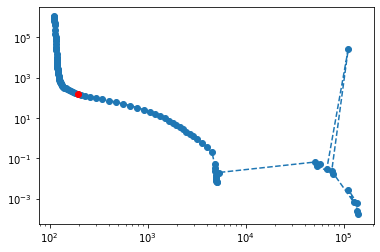

In [15]:
idx = 50
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

(0.0001, 1000.0)

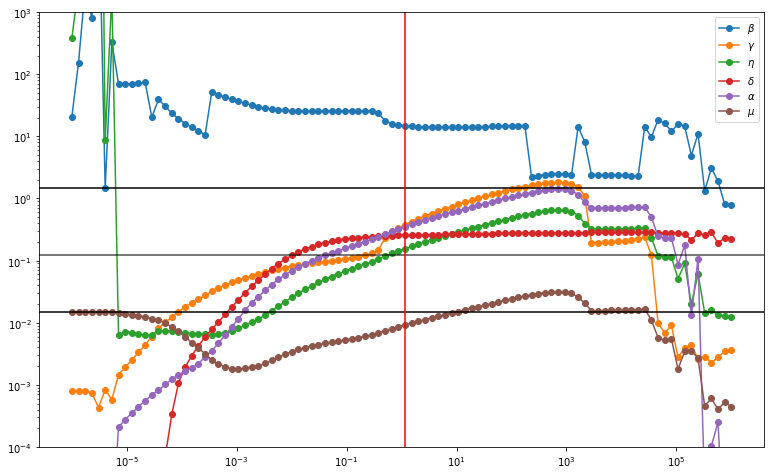

In [16]:
plt.figure(figsize=[13,8])
plt.plot(prange, [float(s['x'][-6]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-5]) for s in sols], 'o-', label=r'$\gamma$')
plt.plot(prange, [float(s['x'][-4]) for s in sols], 'o-', label=r'$\eta$')
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\delta$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\mu$')
for q in p0:
    plt.axhline(q, color='k')
plt.axhline(0.125, color='k', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()
plt.ylim([1e-4, 1e3])

28.7915


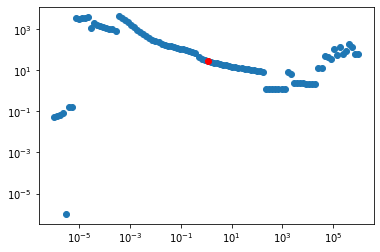

In [17]:
def r0(sol):
    b, g, e, d, a, m = getp(sol['x'])
    return b/(e+a+m)
plt.semilogx(prange, [r0(sol) for sol in sols], 'o')
plt.semilogx(prange[idx], r0(sols[idx]), 'ro')
print(r0(sols[idx]))
plt.yscale('log')

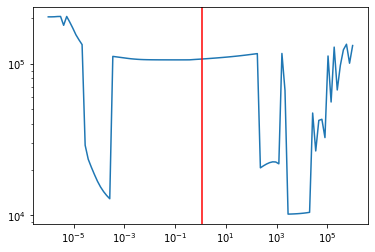

In [18]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])
plt.axvline(prange[idx], color='r')

(DM(14.8499), DM(0.378481), DM(0.155365), DM(0.255512), DM(0.351179), DM(0.00922868))


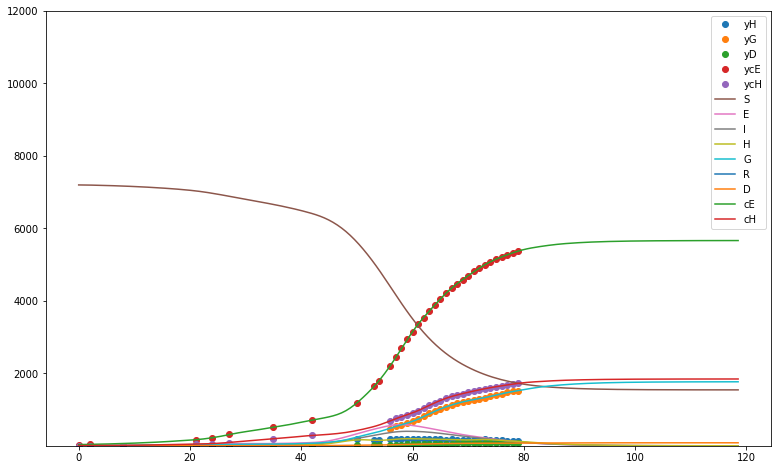

In [19]:
fig, ax=plt.subplots(figsize=[13, 8])
for data_dots in [H,G,D,cE,cH]:
    ax.plot(time, data_dots, 'o')
for data_stripe in getx(sols[idx]['x']):
    ax.plot(model.observation_times, data_stripe)
plt.legend(['yH', 'yG', 'yD', 'ycE', 'ycH', 'S', 'E', 'I', 'H', 'G', 'R', 'D', 'cE', 'cH'])
plt.ylim([1e-5, 12000])
print(getp(sols[idx]['x']))

In [20]:
print(list(zip("bgedam", getp(sols[idx]['x']))))

[(lbl, yyy[np.argmin(np.abs(model.observation_times-65))]) for lbl, yyy in zip('seihgrdEH', getx(sols[idx]['x'])) ]

[('b', DM(14.8499)), ('g', DM(0.378481)), ('e', DM(0.155365)), ('d', DM(0.255512)), ('a', DM(0.351179)), ('m', DM(0.00922868))]


[('s', DM(2664.54)),
 ('e', DM(421.386)),
 ('i', DM(341.621)),
 ('h', DM(179.478)),
 ('g', DM(1019.6)),
 ('r', DM(98657.3)),
 ('d', DM(58.8786)),
 ('E', DM(4062.12)),
 ('H', DM(1255.31))]

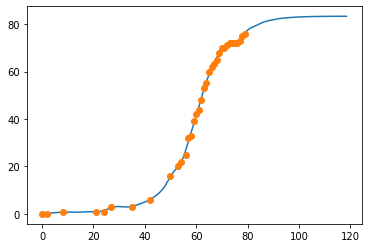

In [21]:
plt.plot(model.observation_times, getx(sols[idx]['x'])[6])
plt.plot(time, D, 'o')

(0, 6000)

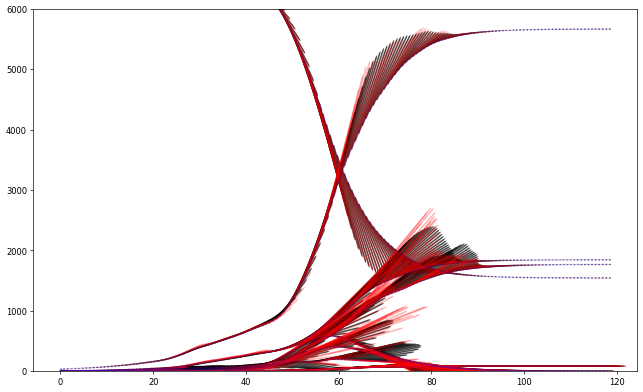

In [22]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
xx = np.vstack([xix.toarray().flatten() for xix in getx(sols[idx]['x'])])
dxxdt = np.vstack([seir(0, xxj, [float(q) for q in getp(sols[idx]['x'])]) for xxj in xx.T])
plt.plot(model.observation_times, xx.T, alpha=0.2, color='b')
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), dxxdt[:,i], 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.7)
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), np.gradient(xxi, model.observation_times), color='r', 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.3)
plt.ylim([0, 6000])

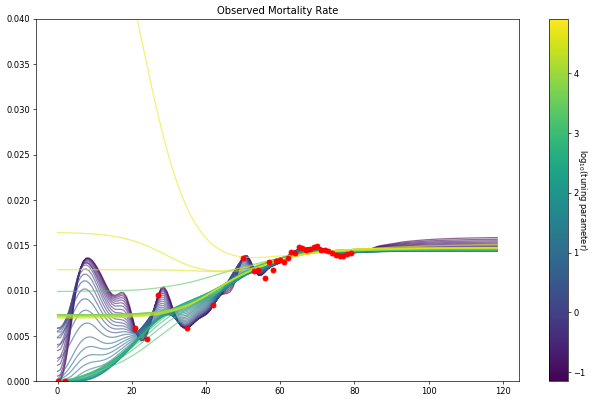

In [23]:

import matplotlib.cm as mplcm
import matplotlib.colors as colors
i0, i1 = (40, -10)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

plt.figure(figsize=[13,8], dpi=60)
for i,p in enumerate(prange[i0:i1]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[6]/getx(sols[i+i0]['x'])[-2], 
             color=scalarMap.to_rgba(np.log10(p)), alpha=0.6)
plt.ylim(0, 0.04)
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.title("Observed Mortality Rate")
plt.plot(time, D/cE, 'ro')

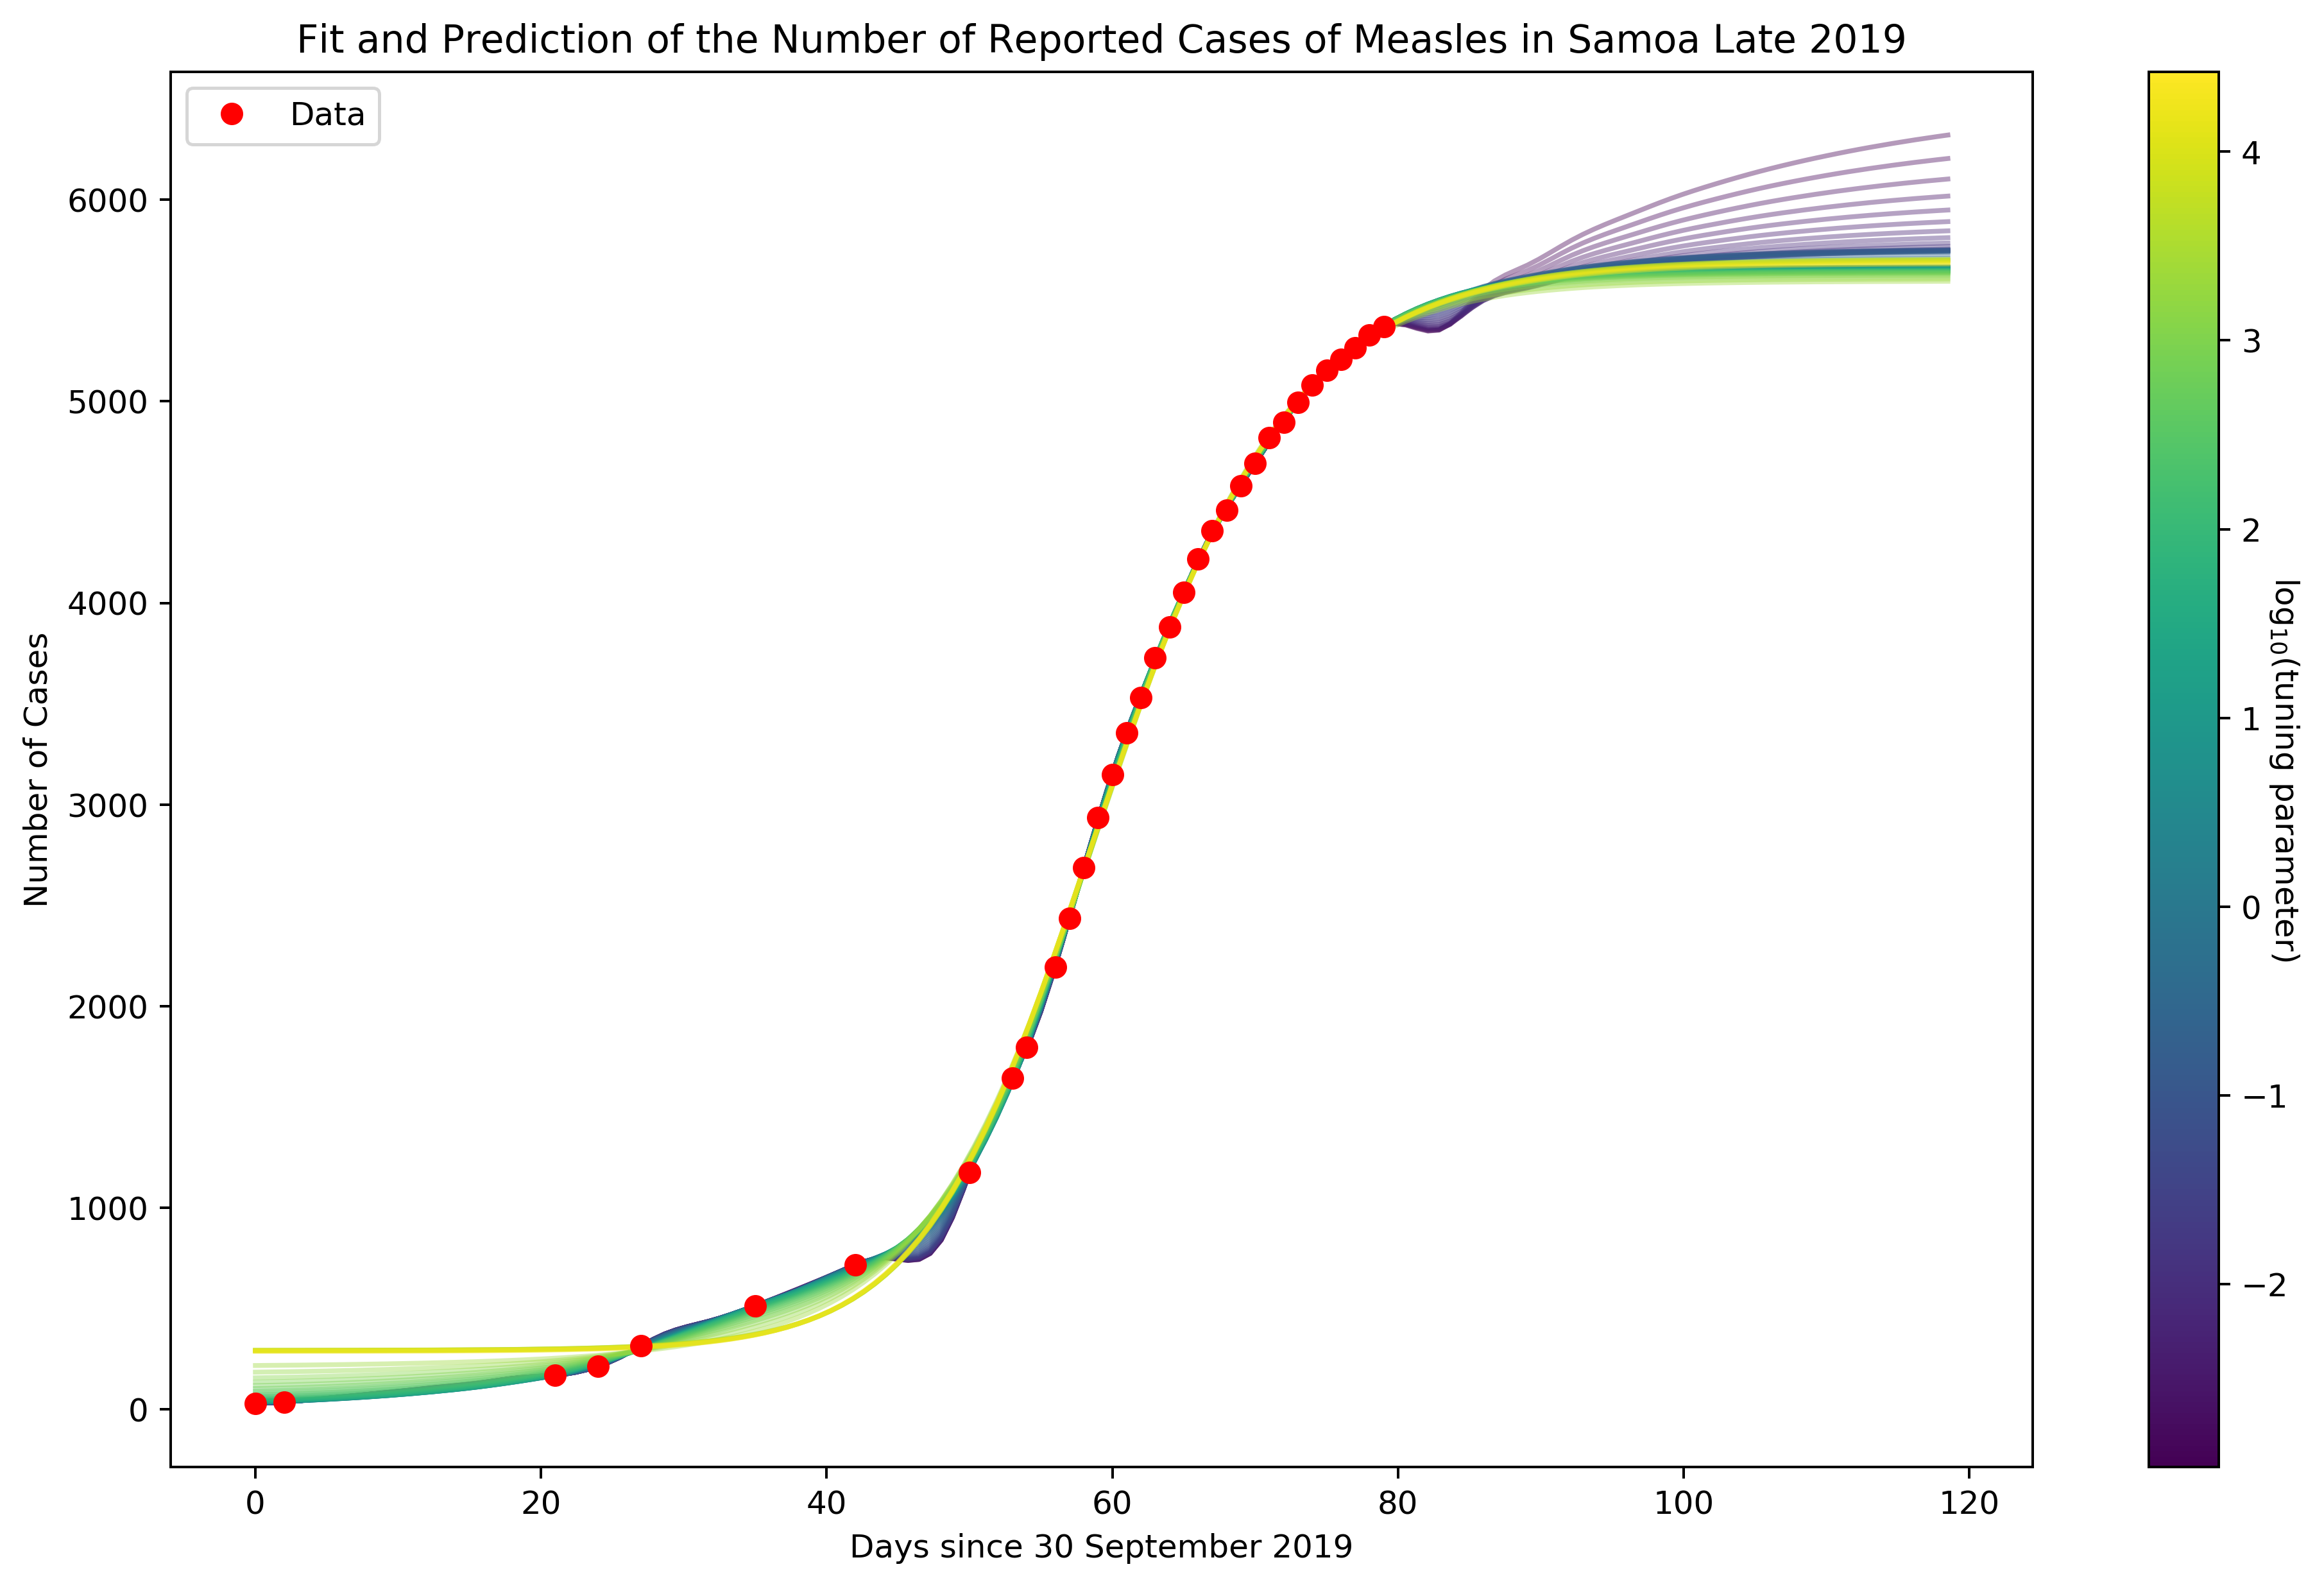

In [24]:
plt.figure(figsize=[13,8], dpi=360)

i0, i1 = (25, -14)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


for i,p in enumerate(prange[i0:i1:]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[-2], color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
plt.plot(time, cE, 'ro', label="Data")
plt.title("Fit and Prediction of the Number of Reported Cases of Measles in Samoa Late 2019")
plt.xlabel("Days since 30 September 2019")
plt.ylabel("Number of Cases")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()

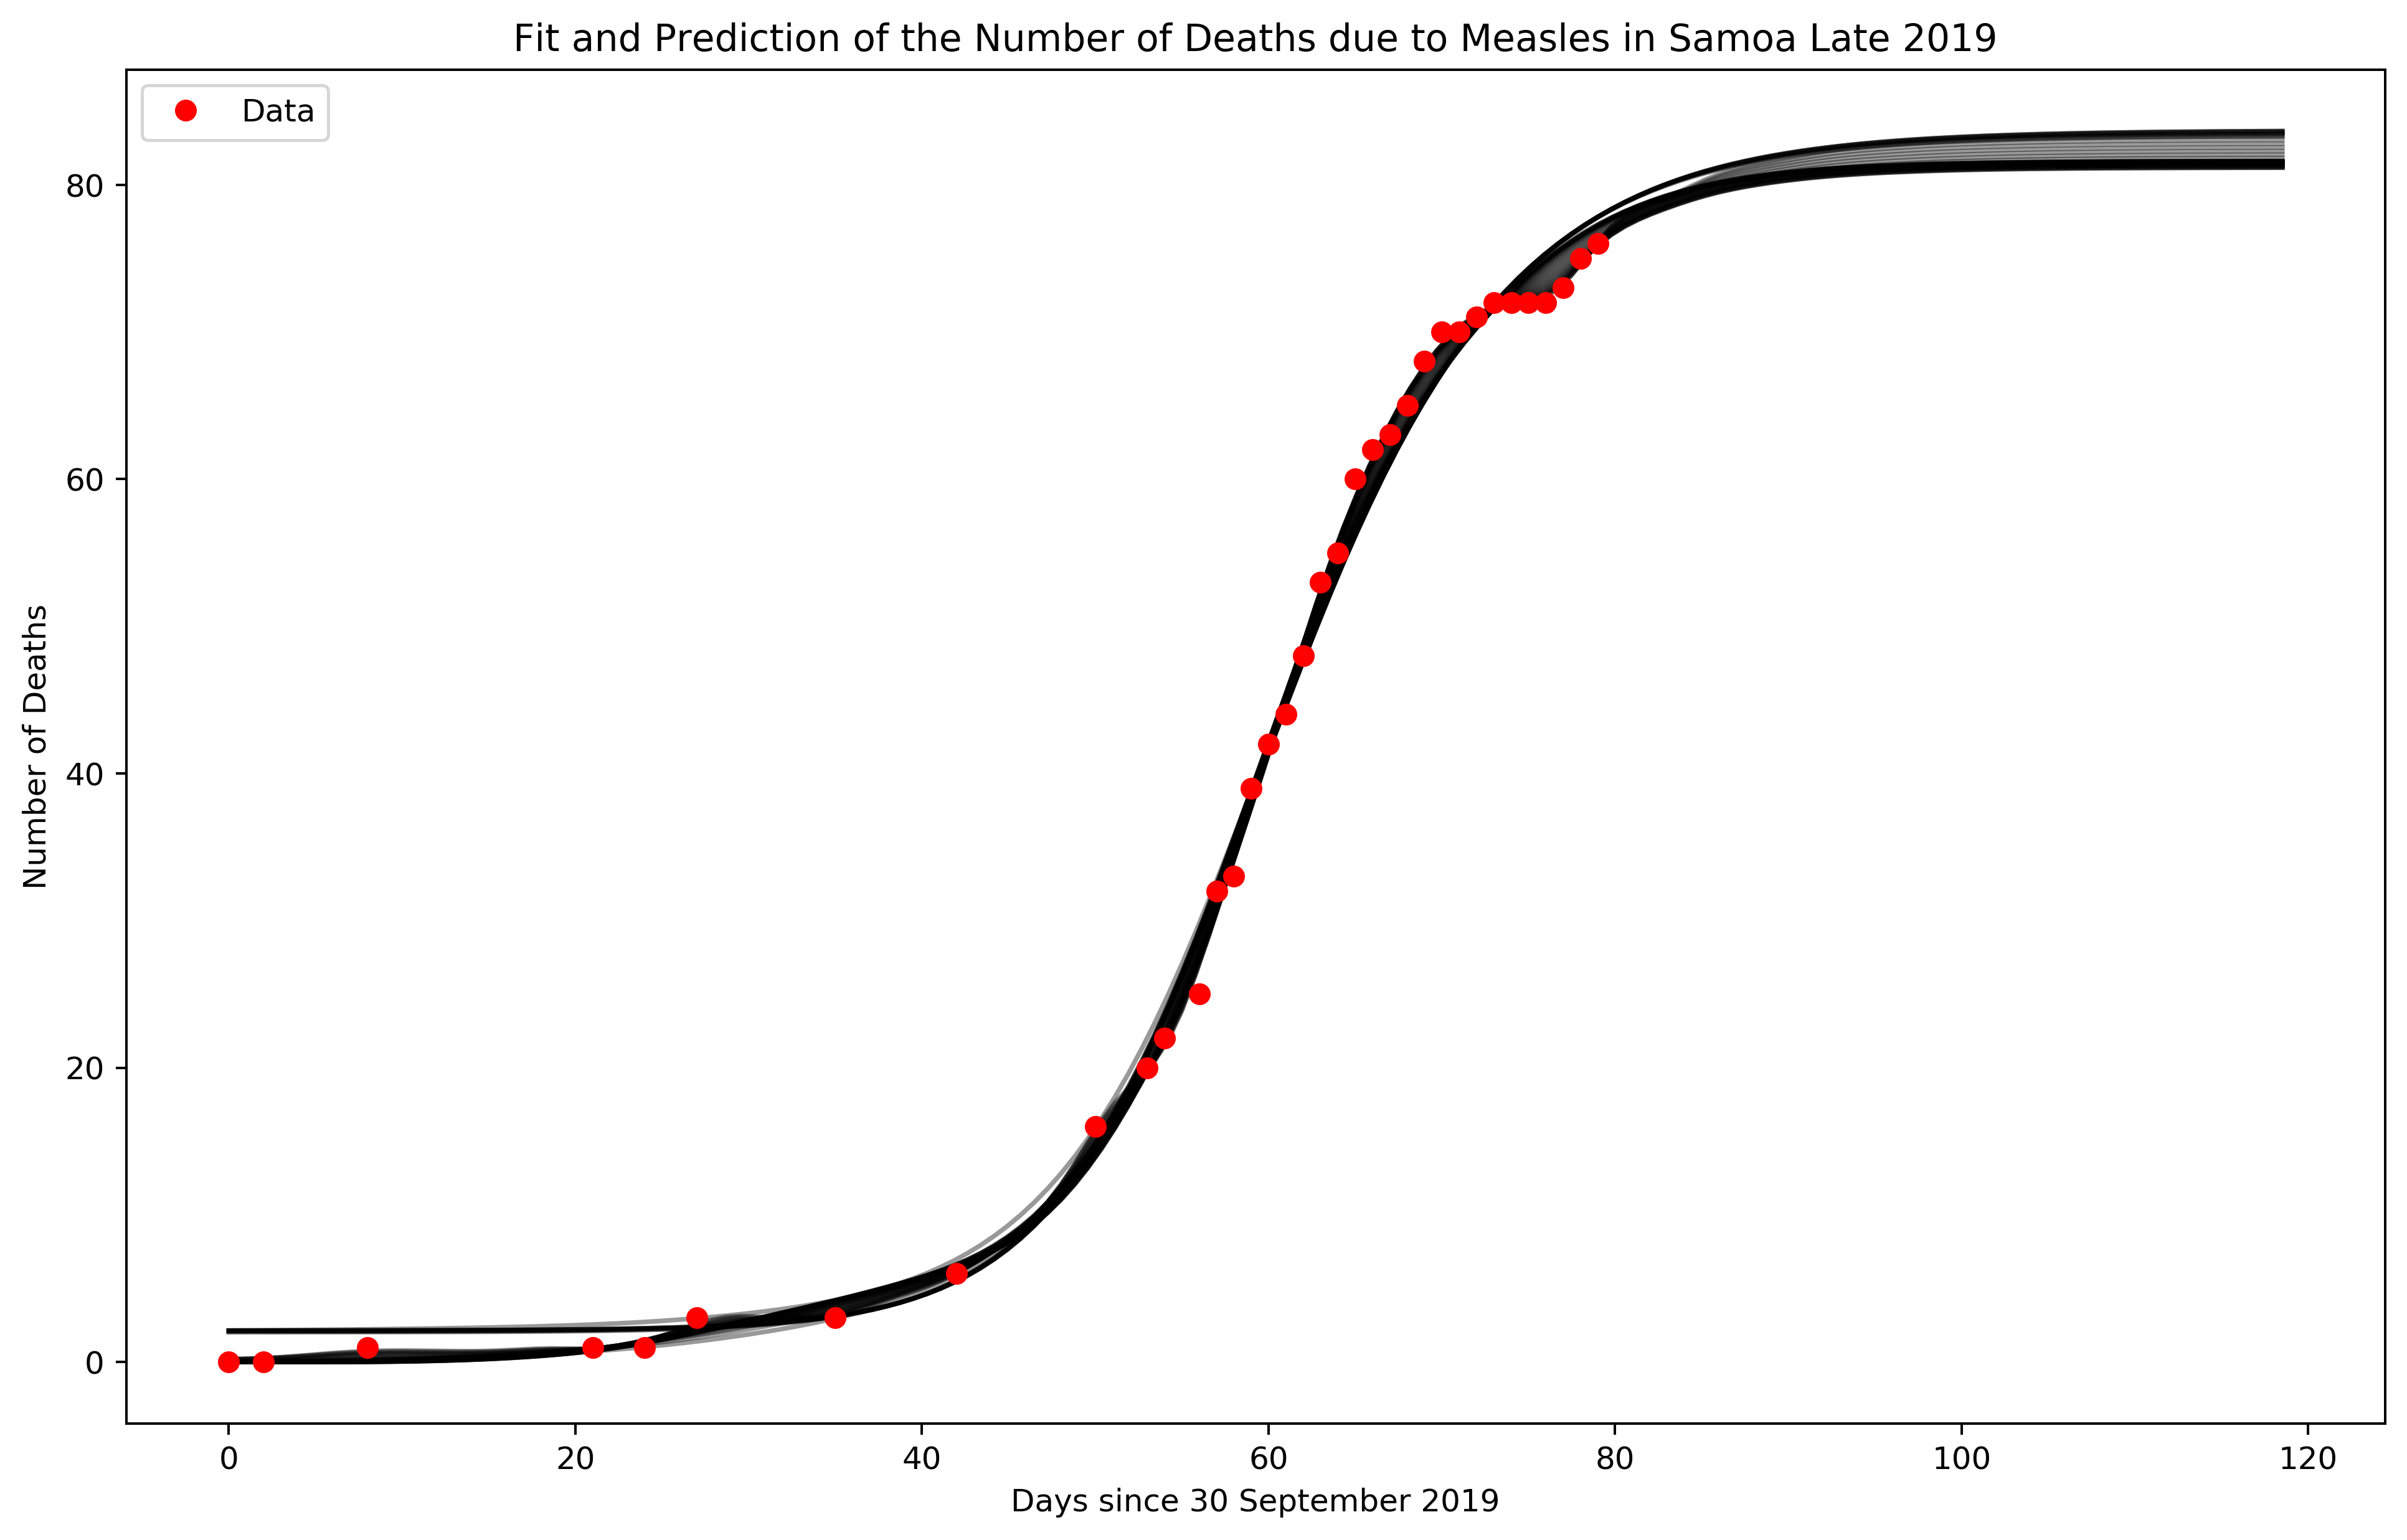

In [25]:
plt.figure(figsize=[13,8], dpi=360)

i0, i1 = (50, -14)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


for i,p in enumerate(prange[i0:i1:]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[6], color='k', alpha=0.4)
plt.plot(time, D, 'ro', label="Data")
plt.title("Fit and Prediction of the Number of Deaths due to Measles in Samoa Late 2019")
plt.xlabel("Days since 30 September 2019")
plt.ylabel("Number of Deaths")
# cbar = plt.colorbar(scalarMap)
# cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()

array([5751.19584758, 5751.19584758])

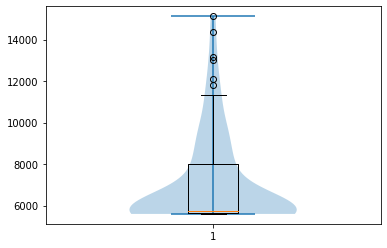

In [26]:
plt.violinplot([getx(sols[i]['x'])[-2][-1] for i in range(100)])
bx=plt.boxplot([getx(sols[i]['x'])[-2][-1] for i in range(100)])
bx['medians'][0].get_ydata()
# plt.yscale('log')

In [27]:
np.min([getx(sols[i]['x'])[-2][-1] for i in range(100)])

5595.888038144121

In [28]:
np.unique(bx['boxes'][0].get_ydata())

array([5663.80830051, 8011.81560556])

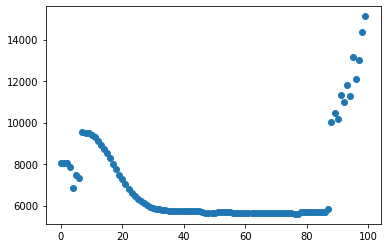

In [29]:
plt.plot([getx(sols[i]['x'])[-2][-1] for i in range(100)],'o')

(0, 100)

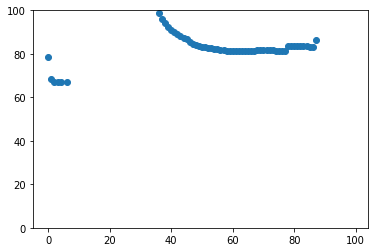

In [30]:
plt.plot([getx(sols[i]['x'])[6][-1] for i in range(100)],'o')
plt.ylim([0, 100])

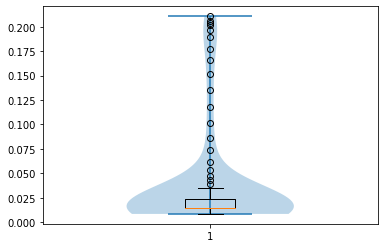

In [31]:
plt.violinplot([(getx(sols[i]['x'])[6]/getx(sols[i]['x'])[-2])[-1] for i in range(100)])
bx = plt.boxplot([(getx(sols[i]['x'])[6]/getx(sols[i]['x'])[-2])[-1] for i in range(100)])


In [32]:
bx['medians'][0].get_xydata()

array([[0.925     , 0.01479102],
       [1.075     , 0.01479102]])

In [33]:
morts = [getx(sols[i]['x'])[6][-1] for i in range(100)]
print(np.min(morts))
print(np.median(morts))

67.04267241566421
87.84474088604108
